In [1]:
import pandas as pd
import numpy as np
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
import os
from supervised.automl import AutoML
import category_encoders as ce
import math

# visualization
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from category_encoders import TargetEncoder
from sklearn.metrics import median_absolute_error
print('Imported sci-kit learn and AutoML libraries!')

Imported sci-kit learn and AutoML libraries!


# Cork Prediction

In [2]:
# new file containing rows with our focused area of Dublin found through exploratory analysis
irl = pd.read_csv('cork-more-fixed.csv', index_col='Unnamed: 0')

In [3]:
irl.head()

,Address,County,Price (€),VAT Exclusive,Description of Property,Property Size Description,Year,Month,Town,Apartment,Neighbourhood,PriceInflation,Eircode,Latitude,Longitude,DistanceCenter,DistanceSchool,DistancePark,DistanceCar
94123,"10 Deerpark Court, Friars Walk, Cork",Cork,280000.0,1,1,2,2014,1,Cork City,0,Friars Walk Cork City,529951.22,T12,51.891104,-8.474261,0.808257,0.371367,0.334321,0.607264
94124,"30 Whitepoint Ave Cobh, Cork",Cork,370000.0,1,1,1,2014,1,Cork City,0,Whitepoint Ave Cobh Cork City,700292.68,T12,51.844802,-8.312442,12.501636,0.597510,5.440909,11.244529
94125,"43 Richmond Hill, Cork",Cork,130000.0,1,1,1,2014,1,Cork City,0,Richmond Hill Cork City,246048.78,T12,51.903869,-8.471192,0.626745,0.323214,0.129914,0.238164
94126,"Vermont, Ballyhooly Rd, Cork",Cork,155000.0,1,1,1,2014,1,Cork City,0,Ballyhooly Road Cork City,293365.85,T12,51.911380,-8.450581,2.096941,0.447549,0.669517,1.805214
94127,"22 Fernwood, Wilton, Cork",Cork,210000.0,1,1,1,2014,1,Wilton,0,Wilton Cork City,397463.41,T12,51.882655,-8.507208,2.943974,0.503091,0.823622,2.329469


In [4]:
irl.shape

(6453, 19)

In [5]:
irl.drop(columns = ['Address', 'County', 'PriceInflation', 'VAT Exclusive', 'Month'], inplace = True)

In [6]:
# this function finds all values that fall within internationally accepted +-10% of actual prices in our predictions
# we can modify the threshold as we feel the need to here
def accuracy_threshold(test, pred, num):
    test = np.array(test)
    pred = np.array(pred)
# get within x% of actual price , not within log price as this will be misleading / incorrect
    test = np.exp(test)
    pred = np.exp(pred)
    count = 0
    for i in range(len(pred)):
        if test[i] != 0:  
            ten = test[i] * num
            res = test[i] - pred[i]
        else:
            res = 0
            ten = 0
        
        if res < 0:
            res = res * -1
        else:
            res = res
            
        if res <= ten:
            count += 1
        else:
            continue
    return (count / len(test))

In [7]:
encoder = TargetEncoder()
irl['Town'] = encoder.fit_transform(irl['Town'], irl['Price (€)'])

In [8]:
irl.head(1)

,Price (€),Description of Property,Property Size Description,Year,Town,Apartment,Neighbourhood,Eircode,Latitude,Longitude,DistanceCenter,DistanceSchool,DistancePark,DistanceCar
94123,280000.0,1,2,2014,238889.733351,0,Friars Walk Cork City,T12,51.891104,-8.474261,0.808257,0.371367,0.334321,0.607264


In [9]:
encoder = TargetEncoder()
irl['Neighbourhood'] = encoder.fit_transform(irl['Neighbourhood'], irl['Price (€)'])

In [10]:
irl['Neighbourhood'] = irl['Neighbourhood'].round()

In [11]:
encoder = TargetEncoder()
irl['Eircode'] = encoder.fit_transform(irl['Eircode'], irl['Price (€)'])

In [12]:
irl.head()

,Price (€),Description of Property,Property Size Description,Year,Town,Apartment,Neighbourhood,Eircode,Latitude,Longitude,DistanceCenter,DistanceSchool,DistancePark,DistanceCar
94123,280000.0,1,2,2014,238889.733351,0,221996.0,248244.591934,51.891104,-8.474261,0.808257,0.371367,0.334321,0.607264
94124,370000.0,1,1,2014,238889.733351,0,342890.0,248244.591934,51.844802,-8.312442,12.501636,0.597510,5.440909,11.244529
94125,130000.0,1,1,2014,238889.733351,0,150351.0,248244.591934,51.903869,-8.471192,0.626745,0.323214,0.129914,0.238164
94126,155000.0,1,1,2014,238889.733351,0,273440.0,248244.591934,51.911380,-8.450581,2.096941,0.447549,0.669517,1.805214
94127,210000.0,1,1,2014,234741.592357,0,234742.0,248244.591934,51.882655,-8.507208,2.943974,0.503091,0.823622,2.329469


In [13]:
irl['LogPrice (€)'] = np.log(irl['Price (€)'])

In [14]:
irl.head(1)

,Price (€),Description of Property,Property Size Description,Year,Town,Apartment,Neighbourhood,Eircode,Latitude,Longitude,DistanceCenter,DistanceSchool,DistancePark,DistanceCar,LogPrice (€)
94123,280000.0,1,2,2014,238889.733351,0,221996.0,248244.591934,51.891104,-8.474261,0.808257,0.371367,0.334321,0.607264,12.542545


In [15]:
irl.drop(columns = ['Price (€)'], inplace = True)

### Let's try predict a specific years values given some historical data
We will look at using 3 years worth of data and use it to predict some data for a selected year, let's say 2021, now.

In [16]:
specific21 = irl[irl['Year'] > 2017]

A regular train to test split will not suffice here as we need only the years 2018, 2019 and 2020 in our training data, while only using the houses associated with 2021 in our test data.

In [17]:
specific21[specific21['Year'] == 2021].head()

,Description of Property,Property Size Description,Year,Town,Apartment,Neighbourhood,Eircode,Latitude,Longitude,DistanceCenter,DistanceSchool,DistancePark,DistanceCar,LogPrice (€)
101303,1,2,2021,238889.733351,0,211378.0,248244.591934,51.873131,-8.337650,9.675656,0.393688,1.967562,8.895109,11.976659
101304,1,2,2021,238889.733351,0,231068.0,248244.591934,51.917272,-8.445846,2.796181,1.003543,0.560057,2.487215,12.421184
101305,1,2,2021,131675.926848,0,131877.0,248244.591934,51.915242,-8.478741,1.930380,0.527584,0.319882,1.565576,12.028739
101306,1,2,2021,238889.733351,0,149467.0,248244.591934,51.907005,-8.461265,1.241596,0.372963,0.594080,0.938153,12.570716
101307,1,2,2021,238889.733351,0,248949.0,248244.591934,51.882794,-8.505025,2.814969,0.620525,0.678898,2.209840,12.367341


In [18]:
specific21.shape[0]

3113

In [19]:
train_21 = specific21[specific21['Year'] < 2021]

In [20]:
#train_21 = train_21.sample(n = 80000)
train_21.head()

,Description of Property,Property Size Description,Year,Town,Apartment,Neighbourhood,Eircode,Latitude,Longitude,DistanceCenter,DistanceSchool,DistancePark,DistanceCar,LogPrice (€)
97516,1,1,2019,238889.733351,0,168643.0,248244.591934,51.905063,-8.481322,0.961035,0.146350,0.423376,0.511415,12.345835
97517,1,1,2019,238889.733351,0,422381.0,248244.591934,51.875108,-8.412160,4.884367,0.961080,1.431026,3.778074,12.860999
97518,1,1,2019,238889.733351,0,136372.0,248244.591934,51.919905,-8.490193,2.688469,0.421540,0.187103,2.266607,12.043554
97519,1,0,2019,238889.733351,0,149467.0,248244.591934,51.907005,-8.461265,1.241596,0.372963,0.594080,0.938153,12.287653
97520,1,0,2019,238889.733351,0,422381.0,248244.591934,51.875108,-8.412160,4.884367,0.961080,1.431026,3.778074,13.361380


In [21]:
test_21 = specific21[specific21['Year'] == 2021]

In [22]:
x_train_21 = train_21.loc[:, train_21.columns != 'LogPrice (€)']
y_train_21 = train_21['LogPrice (€)']

In [23]:
#x_train_21.drop(columns=['Year'], inplace = True)

In [24]:
#test_21 = test_21.sample(n = 15000)
test_21.head()

,Description of Property,Property Size Description,Year,Town,Apartment,Neighbourhood,Eircode,Latitude,Longitude,DistanceCenter,DistanceSchool,DistancePark,DistanceCar,LogPrice (€)
101303,1,2,2021,238889.733351,0,211378.0,248244.591934,51.873131,-8.337650,9.675656,0.393688,1.967562,8.895109,11.976659
101304,1,2,2021,238889.733351,0,231068.0,248244.591934,51.917272,-8.445846,2.796181,1.003543,0.560057,2.487215,12.421184
101305,1,2,2021,131675.926848,0,131877.0,248244.591934,51.915242,-8.478741,1.930380,0.527584,0.319882,1.565576,12.028739
101306,1,2,2021,238889.733351,0,149467.0,248244.591934,51.907005,-8.461265,1.241596,0.372963,0.594080,0.938153,12.570716
101307,1,2,2021,238889.733351,0,248949.0,248244.591934,51.882794,-8.505025,2.814969,0.620525,0.678898,2.209840,12.367341


In [25]:
x_test_21 = test_21.loc[:, test_21.columns != 'LogPrice (€)']
y_test_21 = test_21['LogPrice (€)']

In [26]:
## explain_level gives information on feature importance when given value 1 or 2
automl1 = AutoML(total_time_limit = 5 * 60, explain_level = 2)
automl1.fit(x_train_21, y_train_21)

AutoML directory: AutoML_1
The task is regression with evaluation metric rmse
AutoML will use algorithms: ['Baseline', 'Linear', 'Decision Tree', 'Random Forest', 'Xgboost', 'Neural Network']
AutoML will ensemble available models
AutoML steps: ['simple_algorithms', 'default_algorithms', 'ensemble']
* Step simple_algorithms will try to check up to 3 models
1_Baseline rmse 0.536044 trained in 0.93 seconds
2_DecisionTree rmse 0.425967 trained in 30.12 seconds
3_Linear rmse 0.412445 trained in 5.88 seconds
* Step default_algorithms will try to check up to 3 models
4_Default_Xgboost rmse 0.405341 trained in 6.68 seconds
5_Default_NeuralNetwork rmse 0.422974 trained in 1.41 seconds
6_Default_RandomForest rmse 0.411253 trained in 6.06 seconds
* Step ensemble will try to check up to 1 model
Ensemble rmse 0.399748 trained in 0.77 seconds
AutoML fit time: 69.82 seconds
AutoML best model: Ensemble


AutoML(explain_level=2, total_time_limit=300)

In [27]:
# calculated values
y_predicted_21 = automl1.predict(x_test_21)
  
# Calculation of Mean Squared Error (MSE)
mse = mean_squared_error(y_test_21, y_predicted_21)
print('MSE for AutoML 2021 is: ' + str(mse))

MSE for AutoML 2021 is: 0.16717321912763


In [28]:
rmse = mean_squared_error(y_test_21, y_predicted_21, squared = False)
print('RMSE for AutoML 2021 is: ' + str(rmse))

RMSE for AutoML 2021 is: 0.40886821731167855


In [29]:
acc = accuracy_threshold(y_test_21, y_predicted_21, 0.1)
print('Accuracy of properties at +- 10% of actual prices is ' + str(acc))

Accuracy of properties at +- 10% of actual prices is 0.26525198938992045


In [30]:
acc1 = accuracy_threshold(y_test_21, y_predicted_21, 0.20)
print('Accuracy of properties at +- 20% of actual prices is ' + str(acc1))

Accuracy of properties at +- 20% of actual prices is 0.506631299734748


In [31]:
median_se = np.square(np.subtract(y_test_21, y_predicted_21)).median() 
 
med = math.sqrt(median_se)
print("Median Absolute Error:\n")
print(med)

Median Absolute Error:

0.20496827585556057


In [32]:
from sklearn.metrics import mean_absolute_percentage_error
mape = mean_absolute_percentage_error(y_test_21, y_predicted_21)
print("MAPE for AutoML 2021 is: " + str(mape))

MAPE for AutoML 2021 is: 0.023204984030492527


In [33]:
cnames=['Algorithm', 'Year', 'RMSE', 'MSE', 'MEDAE', 'Accuracy', 'MAPE']
df11 = pd.DataFrame(columns=cnames)

df11 = df11.append({'Algorithm': 'AutoML',
            'Year': 2021,
           'RMSE': rmse,
           'MSE': mse,
           'MEDAE': med,
           'Accuracy': acc,
           'MAPE': mape         
          }, ignore_index=True)

In [34]:
#cnames = ['Actual', 'Predicted']
#dfreal1 = pd.DataFrame(columns = cnames)
dfreal1 = pd.DataFrame(y_test_21.values)
dfpred1 = pd.DataFrame(y_predicted_21)

### 2020 predictions

In [35]:
specific20 = irl[irl['Year'] > 2016]

In [36]:
test_20 = specific20[specific20['Year'] == 2020]
train_20 = specific20[specific20['Year'] < 2020]

In [37]:
#train_20 = train_20.sample(n = 75000)

In [38]:
x_train_20 = train_20.loc[:, train_20.columns != 'LogPrice (€)']
y_train_20 = train_20['LogPrice (€)']

In [39]:
x_test_20 = test_20.loc[:, test_20.columns != 'LogPrice (€)']
y_test_20 = test_20['LogPrice (€)']

In [40]:
automl2 = AutoML(total_time_limit = 5 * 60, explain_level = 2)
automl2.fit(x_train_20, y_train_20)

AutoML directory: AutoML_2
The task is regression with evaluation metric rmse
AutoML will use algorithms: ['Baseline', 'Linear', 'Decision Tree', 'Random Forest', 'Xgboost', 'Neural Network']
AutoML will ensemble available models
AutoML steps: ['simple_algorithms', 'default_algorithms', 'ensemble']
* Step simple_algorithms will try to check up to 3 models
1_Baseline rmse 0.519297 trained in 1.53 seconds
2_DecisionTree rmse 0.435208 trained in 7.95 seconds
3_Linear rmse 0.420307 trained in 6.05 seconds
* Step default_algorithms will try to check up to 3 models
4_Default_Xgboost rmse 0.426712 trained in 10.68 seconds
5_Default_NeuralNetwork rmse 0.420829 trained in 2.78 seconds
6_Default_RandomForest rmse 0.426453 trained in 7.53 seconds
* Step ensemble will try to check up to 1 model
Ensemble rmse 0.41361 trained in 0.9 seconds
AutoML fit time: 60.29 seconds
AutoML best model: Ensemble


AutoML(explain_level=2, total_time_limit=300)

In [41]:
# calculated values
y_predicted_20 = automl2.predict(x_test_20)
  
# Calculation of Mean Squared Error (MSE)
mse = mean_squared_error(y_test_20,y_predicted_20)
print('MSE for AutoML 2020 is: ' + str(mse))

MSE for AutoML 2020 is: 0.1563215262948508


In [42]:
rmse = mean_squared_error(y_test_20, y_predicted_20, squared=False)
print('RMSE for AutoML 2020 is: ' + str(rmse))

RMSE for AutoML 2020 is: 0.39537517157106716


In [43]:
acc = accuracy_threshold(y_test_20, y_predicted_20, 0.1)
print('Accuracy of properties at +- 10% of actual prices is ' + str(acc))

Accuracy of properties at +- 10% of actual prices is 0.29295774647887324


In [44]:
acc1 = accuracy_threshold(y_test_20, y_predicted_20, 0.2)
print('Accuracy of properties at +- 20% of actual prices is ' + str(acc1))

Accuracy of properties at +- 20% of actual prices is 0.532394366197183


In [45]:
print("Median Absolute Error:\n")
print(median_absolute_error(y_test_20, y_predicted_20))

Median Absolute Error:

0.1850253388751275


In [46]:
mape = mean_absolute_percentage_error(y_test_20, y_predicted_20)
print("MAPE for AutoML 2020 is: " + str(mape))

MAPE for AutoML 2020 is: 0.02227011015108144


In [47]:
cnames = ['Algorithm', 'Year', 'RMSE', 'MSE', 'MEDAE', 'Accuracy', 'MAPE']
df10 = pd.DataFrame(columns=cnames)

df10 = df10.append({'Algorithm': 'AutoML',
            'Year': 2020,
           'RMSE': rmse,
           'MSE': mse,
           'MEDAE': med,
           'Accuracy': acc,
           'MAPE': mape
          }, ignore_index=True)

In [48]:
x_test_20

,Description of Property,Property Size Description,Year,Town,Apartment,Neighbourhood,Eircode,Latitude,Longitude,DistanceCenter,DistanceSchool,DistancePark,DistanceCar
0,1,1,2020,238889.733351,1,322036.0,248244.591934,51.889884,-8.538672,4.629442,1.484108,1.068568,3.958792
1,1,1,2020,238889.733351,0,333240.0,248244.591934,51.878132,-8.436607,3.336313,0.451238,0.324759,2.083371
2,1,1,2020,234741.592357,0,234742.0,248244.591934,51.881036,-8.503579,2.864464,0.609113,0.567662,2.285724
3,1,1,2020,238889.733351,0,230892.0,248244.591934,51.915896,-8.451011,2.453867,0.701465,0.404339,2.129879
4,1,1,2020,238889.733351,0,136372.0,248244.591934,51.919905,-8.490193,2.688469,0.421540,0.187103,2.266607
...,...,...,...,...,...,...,...,...,...,...,...,...,...
705,1,2,2020,281978.748081,0,189891.0,248244.591934,51.869345,-8.442395,3.829340,0.431347,0.436788,1.957004
706,1,2,2020,326881.984495,0,375326.0,248244.591934,51.878748,-8.514920,3.627960,0.210651,1.378612,3.013648
707,1,2,2020,326881.984495,0,395513.0,248244.591934,51.880926,-8.518769,3.710962,0.506495,1.150036,3.071412
708,1,2,2020,326881.984495,0,339235.0,248244.591934,51.880079,-8.528767,4.354634,0.212325,0.464748,3.701578


In [49]:
#cnames = ['Actual', 'Predicted']
#dfreal2 = pd.DataFrame(columns = cnames)
dfreal2 = pd.DataFrame(y_test_20.values)
dfpred2 = pd.DataFrame(y_predicted_20)
#dfreal2 = pd.concat([z1, z2], ignore_index=True)

### Multiple Linear Regression

Next, I will try implement some algorithms not specified in our autoML library which so far has only utilised XgBoost, Random Forest, Decison Tree and ensemble algorithms. I will attempt to implement other ML algorithms such as multiple linear regression and adaboost among others.

There is a couple of different libraries we can use here for linear regression:
- Sci-kit learn's linear model library
- Statsmodel

For the purpose of this I will remain consistent with the use of the sci-kit learn libraries.

In [50]:
from sklearn import linear_model

#### Let's try predict our 2021 values again using MLR

In [51]:
lm = linear_model.LinearRegression()
lm.fit(x_train_21, y_train_21) # fitting the model

LinearRegression()

In [52]:
y_pred_21 = lm.predict(x_test_21)
# Calculation of Mean Squared Error (MSE)
mse = mean_squared_error(y_test_21,y_pred_21)
print('MSE for MLR 2021 is: ' + str(mse))

MSE for MLR 2021 is: 0.16923068136895392


In [53]:
acc = accuracy_threshold(y_test_21, y_pred_21, 0.1)
print('Accuracy of properties at +- 10% of actual prices is ' + str(acc))

Accuracy of properties at +- 10% of actual prices is 0.2546419098143236


In [54]:
acc1 = accuracy_threshold(y_test_21, y_pred_21, 0.20)
print('Accuracy of properties at +- 20% of actual prices is ' + str(acc1))

Accuracy of properties at +- 20% of actual prices is 0.4827586206896552


In [55]:
median_se = np.square(np.subtract(y_test_21,y_pred_21)).median() 
 
med = math.sqrt(median_se)
print("Median Absolute Error:\n")
print(med)

Median Absolute Error:

0.2216109004776898


In [56]:
mean = np.square(np.subtract(y_test_21,y_pred_21)).mean() 
 
mean = math.sqrt(mean)
print("Root Mean Square Error:\n")
print(mean)

Root Mean Square Error:

0.41137656881372586


In [57]:
mape = mean_absolute_percentage_error(y_test_21, y_pred_21)
print("MAPE for MLR 2021 is: " + str(mape))

MAPE for MLR 2021 is: 0.02369173825546289


In [58]:
cnames=['Algorithm', 'Year', 'RMSE', 'MSE', 'MEDAE', 'Accuracy', 'MAPE']
df9 = pd.DataFrame(columns=cnames)

df9 = df9.append({'Algorithm': 'MLR',
            'Year': 2021,
           'RMSE': mean,
           'MSE': mse,
           'MEDAE': med,
           'Accuracy': acc,
           'MAPE': mape       
          }, ignore_index=True)

### 2020 predictions

In [59]:
lm = linear_model.LinearRegression()
lm.fit(x_train_20, y_train_20) # fitting the model

LinearRegression()

In [60]:
y_pred_20 = lm.predict(x_test_20)
# Calculation of Mean Squared Error (MSE)
mse = mean_squared_error(y_test_20, y_pred_20)
print('MSE for MLR 2020 is: ' + str(mse))

MSE for MLR 2020 is: 0.16231310776963903


In [61]:
acc = accuracy_threshold(y_test_20, y_pred_20, 0.1)
print('Accuracy of properties at +- 10% of actual prices is ' + str(acc))

Accuracy of properties at +- 10% of actual prices is 0.2859154929577465


In [62]:
acc1 = accuracy_threshold(y_test_20, y_pred_20, 0.15)
print('Accuracy of properties at +- 15% of actual prices is ' + str(acc1))

Accuracy of properties at +- 15% of actual prices is 0.4056338028169014


In [63]:
median_se = np.square(np.subtract(y_test_20, y_pred_20)).median() 
 
med = math.sqrt(median_se)
print("Median Absolute Error:\n")
print(med)

Median Absolute Error:

0.17378340137786275


In [64]:
mean = np.square(np.subtract(y_test_20, y_pred_20)).mean() 
 
mean = math.sqrt(mean)
print("Root Mean Square Error:\n")
print(mean)

Root Mean Square Error:

0.40288100944278676


In [65]:
mape = mean_absolute_percentage_error(y_test_20, y_pred_20)
print("MAPE for MLR 2020 is: " + str(mape))

MAPE for MLR 2020 is: 0.022618388838188393


In [66]:
cnames=['Algorithm', 'Year', 'RMSE', 'MSE', 'MEDAE', 'Accuracy', 'MAPE']
df8 = pd.DataFrame(columns=cnames)

df8 = df8.append({'Algorithm': 'MLR',
            'Year': 2020,
           'RMSE': mean,
           'MSE': mse,
           'MEDAE': med,
           'Accuracy': acc,
           'MAPE': mape       
          }, ignore_index=True)

### Adaboost

#### 2021 Predictions

In [67]:
from sklearn.ensemble import AdaBoostRegressor
from sklearn.datasets import make_regression

In [68]:
model = AdaBoostRegressor()

In [69]:
model.fit(x_train_21, y_train_21)

AdaBoostRegressor()

In [70]:
y_pred_21 = model.predict(x_test_21)
# Calculation of Mean Squared Error (MSE)
mse = mean_squared_error(y_test_21,y_pred_21)
print('MSE for AdaBoost 2021 is: ' + str(mse))

MSE for AdaBoost 2021 is: 0.18075262105836698


In [71]:
acc = accuracy_threshold(y_test_21, y_pred_21, 0.1)
print('Accuracy of properties at +- 10% of actual prices is ' + str(acc))

Accuracy of properties at +- 10% of actual prices is 0.23607427055702918


In [72]:
acc1 = accuracy_threshold(y_test_21, y_pred_21, 0.20)
print('Accuracy of properties at +- 20% of actual prices is ' + str(acc1))

Accuracy of properties at +- 20% of actual prices is 0.4416445623342175


In [73]:
median_se = np.square(np.subtract(y_test_21, y_pred_21)).median() 
 
med = math.sqrt(median_se)
print("Median Absolute Error:\n")
print(med)

Median Absolute Error:

0.2438979007744658


In [74]:
mean = np.square(np.subtract(y_test_21, y_pred_21)).mean() 
 
mean = math.sqrt(mean)
print("Root Mean Square Error:\n")
print(mean)

Root Mean Square Error:

0.42515011591009444


In [75]:
mape = mean_absolute_percentage_error(y_test_21, y_pred_21)
print("MAPE for AdaBoost 2021 is: " + str(mape))

MAPE for AdaBoost 2021 is: 0.025188406934404124


In [76]:
cnames=['Algorithm', 'Year', 'RMSE', 'MSE', 'MEDAE', 'Accuracy', 'MAPE']
df7 = pd.DataFrame(columns=cnames)

df7 = df7.append({'Algorithm': 'AdaBoost',
            'Year': 2021,
           'RMSE': mean,
           'MSE': mse,
           'MEDAE': med,
           'Accuracy': acc,
           'MAPE': mape       
          }, ignore_index=True)

#### 2020 Predictions

In [77]:
model = AdaBoostRegressor()
model.fit(x_train_20, y_train_20)

AdaBoostRegressor()

In [78]:
y_pred_20 = model.predict(x_test_20)
# Calculation of Mean Squared Error (MSE)
mse = mean_squared_error(y_test_20, y_pred_20)
print('MSE for AdaBoost 2020 is: ' + str(mse))

MSE for AdaBoost 2020 is: 0.17182840338648428


In [79]:
acc = accuracy_threshold(y_test_20, y_pred_20, 0.1)
print('Accuracy of properties at +- 10% of actual prices is ' + str(acc))

Accuracy of properties at +- 10% of actual prices is 0.28450704225352114


In [80]:
acc1 = accuracy_threshold(y_test_20, y_pred_20, 0.20)
print('Accuracy of properties at +- 20% of actual prices is ' + str(acc1))

Accuracy of properties at +- 20% of actual prices is 0.5056338028169014


In [81]:
median_se = np.square(np.subtract(y_test_20, y_pred_20)).median() 
 
med = math.sqrt(median_se)
print("Median Absolute Error:\n")
print(med)

Median Absolute Error:

0.21150993273906565


In [82]:
mean = np.square(np.subtract(y_test_20, y_pred_20)).mean() 
 
mean = math.sqrt(mean)
print("Root Mean Square Error:\n")
print(mean)

Root Mean Square Error:

0.4145218973546327


In [83]:
mape = mean_absolute_percentage_error(y_test_20, y_pred_20)
print("MAPE for AdaBoost 2020 is: " + str(mape))

MAPE for AdaBoost 2020 is: 0.024094421506991315


In [84]:
cnames=['Algorithm', 'Year', 'RMSE', 'MSE', 'MEDAE', 'Accuracy', 'MAPE']
df6 = pd.DataFrame(columns = cnames)

df6 = df6.append({'Algorithm': 'AdaBoost',
            'Year': 2020,
           'RMSE': mean,
           'MSE': mse,
           'MEDAE': med,
           'Accuracy': acc,
           'MAPE': mape       
          }, ignore_index=True)

## Let's now try a selection of other algorithms on our data
### LightGBM

In [85]:
from sklearn.datasets import make_regression
from lightgbm import LGBMRegressor

### 2020 House Price Prediction Using LightGBM

In [86]:
model = LGBMRegressor()
model.fit(x_train_20, y_train_20)

LGBMRegressor()

In [87]:
y_pred_20 = model.predict(x_test_20)
# Calculation of Mean Squared Error (MSE)
mse = mean_squared_error(y_test_20,y_pred_20)
print('MSE for LightGBM 2020 is: ' + str(mse))

MSE for LightGBM 2020 is: 0.18236490043581466


In [88]:
acc = accuracy_threshold(y_test_20, y_pred_20, 0.1)
print('Accuracy of properties at +- 10% of actual prices is ' + str(acc))

Accuracy of properties at +- 10% of actual prices is 0.2704225352112676


In [89]:
acc1 = accuracy_threshold(y_test_20, y_pred_20, 0.20)
print('Accuracy of properties at +- 20% of actual prices is ' + str(acc1))

Accuracy of properties at +- 20% of actual prices is 0.48732394366197185


In [90]:
median_se = np.square(np.subtract(y_test_20,y_pred_20)).median() 
 
med = math.sqrt(median_se)
print("Median Absolute Error:\n")
print(med)

Median Absolute Error:

0.20587175590130188


In [91]:
mean = np.square(np.subtract(y_test_20,y_pred_20)).mean() 
 
mean = math.sqrt(mean)
print("Root Mean Square Error:\n")
print(mean)

Root Mean Square Error:

0.42704203591194


In [92]:
mape = mean_absolute_percentage_error(y_test_20, y_pred_20)
print("MAPE for LightGBM 2020 is: " + str(mape))

MAPE for LightGBM 2020 is: 0.02440406488680804


In [93]:
cnames=['Algorithm', 'Year', 'RMSE', 'MSE', 'MEDAE', 'Accuracy', 'MAPE']
df5 = pd.DataFrame(columns=cnames)

df5 = df5.append({'Algorithm': 'LightGBM',
            'Year': 2020,
           'RMSE': mean,
           'MSE': mse,
           'MEDAE': med,
           'Accuracy': acc,
           'MAPE': mape       
          }, ignore_index=True)

### 2021

In [94]:
model = LGBMRegressor()
model.fit(x_train_21, y_train_21)

LGBMRegressor()

In [95]:
y_pred_21 = model.predict(x_test_21)
# Calculation of Mean Squared Error (MSE)
mse = mean_squared_error(y_test_21,y_pred_21)
print('MSE for LightGBM 2021 is: ' + str(mse))

MSE for LightGBM 2021 is: 0.19553015520119715


In [96]:
acc = accuracy_threshold(y_test_21, y_pred_21, 0.1)
print('Accuracy of properties at +- 10% of actual prices is ' + str(acc))

Accuracy of properties at +- 10% of actual prices is 0.23342175066312998


In [97]:
acc1 = accuracy_threshold(y_test_21, y_pred_21, 0.20)
print('Accuracy of properties at +- 20% of actual prices is ' + str(acc1))

Accuracy of properties at +- 20% of actual prices is 0.4562334217506631


In [98]:
median_se = np.square(np.subtract(y_test_21, y_pred_21)).median() 
 
med = math.sqrt(median_se)
print("Median Absolute Error:\n")
print(med)

Median Absolute Error:

0.2322436627410352


In [99]:
mean = np.square(np.subtract(y_test_21, y_pred_21)).mean() 
 
mean = math.sqrt(mean)
print("Root Mean Square Error:\n")
print(mean)

Root Mean Square Error:

0.44218791842518396


In [100]:
mape = mean_absolute_percentage_error(y_test_21, y_pred_21)
print("MAPE for LightGBM 2021 is: " + str(mape))

MAPE for LightGBM 2021 is: 0.025475201789381455


In [101]:
cnames=['Algorithm', 'Year', 'RMSE', 'MSE', 'MEDAE', 'Accuracy', 'MAPE']
df4 = pd.DataFrame(columns=cnames)

df4 = df4.append({'Algorithm': 'LightGBM',
            'Year': 2021,
           'RMSE': mean,
           'MSE': mse,
           'MEDAE': med,
           'Accuracy': acc,
           'MAPE': mape       
          }, ignore_index=True)

### CatBoost

#### 2021 Prediction

In [102]:
from catboost import CatBoostRegressor

In [103]:
model = CatBoostRegressor()
model.fit(x_train_21, y_train_21)

Learning rate set to 0.046889
0:	learn: 0.5071041	total: 135ms	remaining: 2m 14s
1:	learn: 0.4993926	total: 138ms	remaining: 1m 8s
2:	learn: 0.4924235	total: 142ms	remaining: 47.1s
3:	learn: 0.4852840	total: 145ms	remaining: 36.1s
4:	learn: 0.4788264	total: 149ms	remaining: 29.6s
5:	learn: 0.4728276	total: 152ms	remaining: 25.2s
6:	learn: 0.4671700	total: 156ms	remaining: 22.1s
7:	learn: 0.4624447	total: 159ms	remaining: 19.8s
8:	learn: 0.4577991	total: 163ms	remaining: 17.9s
9:	learn: 0.4528546	total: 166ms	remaining: 16.5s
10:	learn: 0.4484867	total: 170ms	remaining: 15.3s
11:	learn: 0.4445916	total: 173ms	remaining: 14.3s
12:	learn: 0.4406152	total: 178ms	remaining: 13.5s
13:	learn: 0.4371495	total: 182ms	remaining: 12.8s
14:	learn: 0.4344324	total: 187ms	remaining: 12.3s
15:	learn: 0.4312943	total: 191ms	remaining: 11.7s
16:	learn: 0.4286910	total: 195ms	remaining: 11.3s
17:	learn: 0.4259026	total: 200ms	remaining: 10.9s
18:	learn: 0.4234396	total: 204ms	remaining: 10.5s
19:	learn:

182:	learn: 0.3572919	total: 817ms	remaining: 3.65s
183:	learn: 0.3571950	total: 821ms	remaining: 3.64s
184:	learn: 0.3570580	total: 824ms	remaining: 3.63s
185:	learn: 0.3569101	total: 828ms	remaining: 3.62s
186:	learn: 0.3568488	total: 831ms	remaining: 3.61s
187:	learn: 0.3567142	total: 835ms	remaining: 3.6s
188:	learn: 0.3566183	total: 838ms	remaining: 3.6s
189:	learn: 0.3564753	total: 842ms	remaining: 3.59s
190:	learn: 0.3564180	total: 845ms	remaining: 3.58s
191:	learn: 0.3563169	total: 849ms	remaining: 3.57s
192:	learn: 0.3561916	total: 852ms	remaining: 3.56s
193:	learn: 0.3560461	total: 856ms	remaining: 3.56s
194:	learn: 0.3559300	total: 859ms	remaining: 3.55s
195:	learn: 0.3558042	total: 863ms	remaining: 3.54s
196:	learn: 0.3556145	total: 867ms	remaining: 3.54s
197:	learn: 0.3554969	total: 871ms	remaining: 3.53s
198:	learn: 0.3554393	total: 875ms	remaining: 3.52s
199:	learn: 0.3553782	total: 878ms	remaining: 3.51s
200:	learn: 0.3552844	total: 883ms	remaining: 3.51s
201:	learn: 0.

342:	learn: 0.3428461	total: 2.16s	remaining: 4.14s
343:	learn: 0.3427542	total: 2.18s	remaining: 4.16s
344:	learn: 0.3426175	total: 2.2s	remaining: 4.17s
345:	learn: 0.3425155	total: 2.21s	remaining: 4.17s
346:	learn: 0.3423751	total: 2.23s	remaining: 4.19s
347:	learn: 0.3422465	total: 2.23s	remaining: 4.18s
348:	learn: 0.3420871	total: 2.24s	remaining: 4.18s
349:	learn: 0.3419297	total: 2.26s	remaining: 4.2s
350:	learn: 0.3418966	total: 2.27s	remaining: 4.19s
351:	learn: 0.3417328	total: 2.27s	remaining: 4.18s
352:	learn: 0.3416906	total: 2.28s	remaining: 4.18s
353:	learn: 0.3415662	total: 2.29s	remaining: 4.18s
354:	learn: 0.3414795	total: 2.3s	remaining: 4.18s
355:	learn: 0.3413781	total: 2.31s	remaining: 4.18s
356:	learn: 0.3413350	total: 2.32s	remaining: 4.18s
357:	learn: 0.3411960	total: 2.33s	remaining: 4.17s
358:	learn: 0.3410855	total: 2.33s	remaining: 4.17s
359:	learn: 0.3410030	total: 2.35s	remaining: 4.17s
360:	learn: 0.3409828	total: 2.35s	remaining: 4.16s
361:	learn: 0.3

513:	learn: 0.3291982	total: 3.16s	remaining: 2.99s
514:	learn: 0.3291110	total: 3.16s	remaining: 2.98s
515:	learn: 0.3290627	total: 3.17s	remaining: 2.97s
516:	learn: 0.3288657	total: 3.17s	remaining: 2.96s
517:	learn: 0.3288118	total: 3.17s	remaining: 2.95s
518:	learn: 0.3287833	total: 3.18s	remaining: 2.95s
519:	learn: 0.3287567	total: 3.18s	remaining: 2.94s
520:	learn: 0.3286576	total: 3.19s	remaining: 2.93s
521:	learn: 0.3285114	total: 3.19s	remaining: 2.92s
522:	learn: 0.3284709	total: 3.2s	remaining: 2.92s
523:	learn: 0.3283835	total: 3.2s	remaining: 2.91s
524:	learn: 0.3283647	total: 3.21s	remaining: 2.9s
525:	learn: 0.3282784	total: 3.21s	remaining: 2.89s
526:	learn: 0.3282444	total: 3.21s	remaining: 2.88s
527:	learn: 0.3282216	total: 3.22s	remaining: 2.88s
528:	learn: 0.3281662	total: 3.22s	remaining: 2.87s
529:	learn: 0.3280703	total: 3.23s	remaining: 2.86s
530:	learn: 0.3280350	total: 3.23s	remaining: 2.85s
531:	learn: 0.3279465	total: 3.23s	remaining: 2.85s
532:	learn: 0.3

679:	learn: 0.3186022	total: 3.85s	remaining: 1.81s
680:	learn: 0.3185733	total: 3.85s	remaining: 1.8s
681:	learn: 0.3184844	total: 3.86s	remaining: 1.8s
682:	learn: 0.3184252	total: 3.86s	remaining: 1.79s
683:	learn: 0.3183579	total: 3.86s	remaining: 1.78s
684:	learn: 0.3182753	total: 3.87s	remaining: 1.78s
685:	learn: 0.3181697	total: 3.87s	remaining: 1.77s
686:	learn: 0.3181619	total: 3.88s	remaining: 1.76s
687:	learn: 0.3181296	total: 3.88s	remaining: 1.76s
688:	learn: 0.3180948	total: 3.88s	remaining: 1.75s
689:	learn: 0.3179981	total: 3.89s	remaining: 1.75s
690:	learn: 0.3179379	total: 3.89s	remaining: 1.74s
691:	learn: 0.3178683	total: 3.89s	remaining: 1.73s
692:	learn: 0.3178619	total: 3.9s	remaining: 1.73s
693:	learn: 0.3178005	total: 3.9s	remaining: 1.72s
694:	learn: 0.3177259	total: 3.9s	remaining: 1.71s
695:	learn: 0.3176650	total: 3.91s	remaining: 1.71s
696:	learn: 0.3176278	total: 3.91s	remaining: 1.7s
697:	learn: 0.3176190	total: 3.92s	remaining: 1.7s
698:	learn: 0.31760

857:	learn: 0.3102903	total: 4.52s	remaining: 748ms
858:	learn: 0.3102824	total: 4.53s	remaining: 743ms
859:	learn: 0.3102186	total: 4.53s	remaining: 737ms
860:	learn: 0.3101789	total: 4.53s	remaining: 732ms
861:	learn: 0.3101448	total: 4.54s	remaining: 726ms
862:	learn: 0.3101371	total: 4.54s	remaining: 721ms
863:	learn: 0.3100648	total: 4.54s	remaining: 715ms
864:	learn: 0.3100446	total: 4.55s	remaining: 710ms
865:	learn: 0.3100001	total: 4.55s	remaining: 704ms
866:	learn: 0.3099892	total: 4.55s	remaining: 699ms
867:	learn: 0.3099750	total: 4.56s	remaining: 693ms
868:	learn: 0.3099142	total: 4.56s	remaining: 688ms
869:	learn: 0.3098870	total: 4.56s	remaining: 682ms
870:	learn: 0.3098377	total: 4.57s	remaining: 677ms
871:	learn: 0.3098120	total: 4.57s	remaining: 671ms
872:	learn: 0.3097451	total: 4.58s	remaining: 666ms
873:	learn: 0.3097005	total: 4.58s	remaining: 660ms
874:	learn: 0.3096027	total: 4.58s	remaining: 655ms
875:	learn: 0.3095753	total: 4.59s	remaining: 649ms
876:	learn: 

In [104]:
y_pred_21 = model.predict(x_test_21)
# Calculation of Mean Squared Error (MSE)
mse = mean_squared_error(y_test_21, y_pred_21)
print('MSE for CatBoost 2021 is: ' + str(mse))

MSE for CatBoost 2021 is: 0.20577581090342636


In [105]:
acc = accuracy_threshold(y_test_21, y_pred_21, 0.1)
print('Accuracy of properties at +- 10% of actual prices is ' + str(acc))

Accuracy of properties at +- 10% of actual prices is 0.23209549071618038


In [106]:
median_se = np.square(np.subtract(y_test_21, y_pred_21)).median() 
 
med = math.sqrt(median_se)
print("Median Absolute Error:\n")
print(med)

Median Absolute Error:

0.22762517887824585


In [107]:
mean = np.square(np.subtract(y_test_21, y_pred_21)).mean() 
 
mean = math.sqrt(mean)
print("Root Mean Square Error:\n")
print(mean)

Root Mean Square Error:

0.45362518768629523


In [108]:
mape = mean_absolute_percentage_error(y_test_21, y_pred_21)
print("MAPE for CatBoost 2021 is: " + str(mape))

MAPE for CatBoost 2021 is: 0.025704706374390755


In [109]:
cnames=['Algorithm', 'Year', 'RMSE', 'MSE', 'MEDAE', 'Accuracy', 'MAPE']
df3 = pd.DataFrame(columns=cnames)

df3 = df3.append({'Algorithm': 'CatBoost',
            'Year': 2021,
           'RMSE': mean,
           'MSE': mse,
           'MEDAE': med,
           'Accuracy': acc,
           'MAPE': mape       
          }, ignore_index=True)

#### 2020

In [110]:
model = CatBoostRegressor()
model.fit(x_train_20, y_train_20)

Learning rate set to 0.04756
0:	learn: 0.5300458	total: 3.99ms	remaining: 3.98s
1:	learn: 0.5210632	total: 7.22ms	remaining: 3.6s
2:	learn: 0.5130502	total: 10.8ms	remaining: 3.6s
3:	learn: 0.5056387	total: 14.5ms	remaining: 3.6s
4:	learn: 0.4987996	total: 18ms	remaining: 3.57s
5:	learn: 0.4924791	total: 21.1ms	remaining: 3.5s
6:	learn: 0.4865976	total: 24.9ms	remaining: 3.53s
7:	learn: 0.4812261	total: 28.5ms	remaining: 3.54s
8:	learn: 0.4761490	total: 33.3ms	remaining: 3.67s
9:	learn: 0.4710760	total: 38.3ms	remaining: 3.79s
10:	learn: 0.4662651	total: 42.3ms	remaining: 3.8s
11:	learn: 0.4618809	total: 47.4ms	remaining: 3.9s
12:	learn: 0.4575113	total: 52.3ms	remaining: 3.97s
13:	learn: 0.4536773	total: 56.1ms	remaining: 3.95s
14:	learn: 0.4504378	total: 60.3ms	remaining: 3.96s
15:	learn: 0.4470441	total: 64.7ms	remaining: 3.98s
16:	learn: 0.4442680	total: 69.2ms	remaining: 4s
17:	learn: 0.4415312	total: 73.9ms	remaining: 4.03s
18:	learn: 0.4390263	total: 78.3ms	remaining: 4.04s
19:	

168:	learn: 0.3737055	total: 674ms	remaining: 3.31s
169:	learn: 0.3736051	total: 678ms	remaining: 3.31s
170:	learn: 0.3733843	total: 682ms	remaining: 3.3s
171:	learn: 0.3732072	total: 685ms	remaining: 3.3s
172:	learn: 0.3730156	total: 689ms	remaining: 3.29s
173:	learn: 0.3729820	total: 691ms	remaining: 3.28s
174:	learn: 0.3729648	total: 693ms	remaining: 3.27s
175:	learn: 0.3727776	total: 697ms	remaining: 3.26s
176:	learn: 0.3725885	total: 701ms	remaining: 3.26s
177:	learn: 0.3724270	total: 706ms	remaining: 3.26s
178:	learn: 0.3722669	total: 710ms	remaining: 3.26s
179:	learn: 0.3721161	total: 717ms	remaining: 3.27s
180:	learn: 0.3719959	total: 722ms	remaining: 3.27s
181:	learn: 0.3718652	total: 726ms	remaining: 3.26s
182:	learn: 0.3717030	total: 731ms	remaining: 3.26s
183:	learn: 0.3715256	total: 735ms	remaining: 3.26s
184:	learn: 0.3714378	total: 741ms	remaining: 3.26s
185:	learn: 0.3713052	total: 745ms	remaining: 3.26s
186:	learn: 0.3712120	total: 750ms	remaining: 3.26s
187:	learn: 0.

336:	learn: 0.3555264	total: 1.36s	remaining: 2.68s
337:	learn: 0.3554538	total: 1.36s	remaining: 2.67s
338:	learn: 0.3552250	total: 1.37s	remaining: 2.67s
339:	learn: 0.3551300	total: 1.37s	remaining: 2.67s
340:	learn: 0.3550770	total: 1.38s	remaining: 2.66s
341:	learn: 0.3550237	total: 1.38s	remaining: 2.66s
342:	learn: 0.3549872	total: 1.38s	remaining: 2.65s
343:	learn: 0.3549279	total: 1.39s	remaining: 2.65s
344:	learn: 0.3548788	total: 1.39s	remaining: 2.64s
345:	learn: 0.3548132	total: 1.4s	remaining: 2.64s
346:	learn: 0.3546835	total: 1.4s	remaining: 2.63s
347:	learn: 0.3544972	total: 1.4s	remaining: 2.63s
348:	learn: 0.3543473	total: 1.41s	remaining: 2.63s
349:	learn: 0.3543138	total: 1.41s	remaining: 2.62s
350:	learn: 0.3541741	total: 1.41s	remaining: 2.62s
351:	learn: 0.3540611	total: 1.42s	remaining: 2.61s
352:	learn: 0.3539622	total: 1.42s	remaining: 2.61s
353:	learn: 0.3539274	total: 1.43s	remaining: 2.6s
354:	learn: 0.3538543	total: 1.43s	remaining: 2.6s
355:	learn: 0.353

498:	learn: 0.3417334	total: 2.25s	remaining: 2.26s
499:	learn: 0.3417041	total: 2.27s	remaining: 2.27s
500:	learn: 0.3416048	total: 2.27s	remaining: 2.27s
501:	learn: 0.3415983	total: 2.28s	remaining: 2.26s
502:	learn: 0.3415190	total: 2.29s	remaining: 2.26s
503:	learn: 0.3415059	total: 2.29s	remaining: 2.25s
504:	learn: 0.3413787	total: 2.3s	remaining: 2.25s
505:	learn: 0.3412418	total: 2.3s	remaining: 2.25s
506:	learn: 0.3411662	total: 2.31s	remaining: 2.24s
507:	learn: 0.3410970	total: 2.31s	remaining: 2.24s
508:	learn: 0.3410676	total: 2.31s	remaining: 2.23s
509:	learn: 0.3410412	total: 2.32s	remaining: 2.23s
510:	learn: 0.3408978	total: 2.33s	remaining: 2.23s
511:	learn: 0.3408187	total: 2.33s	remaining: 2.22s
512:	learn: 0.3408089	total: 2.33s	remaining: 2.22s
513:	learn: 0.3406986	total: 2.34s	remaining: 2.21s
514:	learn: 0.3405472	total: 2.34s	remaining: 2.21s
515:	learn: 0.3405434	total: 2.35s	remaining: 2.2s
516:	learn: 0.3404673	total: 2.35s	remaining: 2.2s
517:	learn: 0.34

658:	learn: 0.3298744	total: 2.95s	remaining: 1.53s
659:	learn: 0.3298723	total: 2.96s	remaining: 1.52s
660:	learn: 0.3298397	total: 2.96s	remaining: 1.52s
661:	learn: 0.3297685	total: 2.96s	remaining: 1.51s
662:	learn: 0.3296830	total: 2.97s	remaining: 1.51s
663:	learn: 0.3295934	total: 2.97s	remaining: 1.5s
664:	learn: 0.3295914	total: 2.98s	remaining: 1.5s
665:	learn: 0.3295421	total: 2.98s	remaining: 1.49s
666:	learn: 0.3294202	total: 2.98s	remaining: 1.49s
667:	learn: 0.3293674	total: 2.99s	remaining: 1.49s
668:	learn: 0.3292614	total: 3s	remaining: 1.48s
669:	learn: 0.3291854	total: 3s	remaining: 1.48s
670:	learn: 0.3290779	total: 3.01s	remaining: 1.47s
671:	learn: 0.3289681	total: 3.01s	remaining: 1.47s
672:	learn: 0.3288647	total: 3.02s	remaining: 1.47s
673:	learn: 0.3288126	total: 3.02s	remaining: 1.46s
674:	learn: 0.3288107	total: 3.02s	remaining: 1.46s
675:	learn: 0.3287417	total: 3.03s	remaining: 1.45s
676:	learn: 0.3286752	total: 3.03s	remaining: 1.45s
677:	learn: 0.328583

824:	learn: 0.3207351	total: 3.6s	remaining: 764ms
825:	learn: 0.3207144	total: 3.61s	remaining: 760ms
826:	learn: 0.3206711	total: 3.61s	remaining: 755ms
827:	learn: 0.3205676	total: 3.62s	remaining: 751ms
828:	learn: 0.3204992	total: 3.62s	remaining: 746ms
829:	learn: 0.3203817	total: 3.62s	remaining: 742ms
830:	learn: 0.3203042	total: 3.63s	remaining: 737ms
831:	learn: 0.3202943	total: 3.63s	remaining: 733ms
832:	learn: 0.3202577	total: 3.63s	remaining: 729ms
833:	learn: 0.3202203	total: 3.64s	remaining: 724ms
834:	learn: 0.3201834	total: 3.64s	remaining: 720ms
835:	learn: 0.3201249	total: 3.65s	remaining: 715ms
836:	learn: 0.3201017	total: 3.65s	remaining: 711ms
837:	learn: 0.3200532	total: 3.65s	remaining: 706ms
838:	learn: 0.3199947	total: 3.66s	remaining: 702ms
839:	learn: 0.3199018	total: 3.66s	remaining: 697ms
840:	learn: 0.3198474	total: 3.66s	remaining: 693ms
841:	learn: 0.3197780	total: 3.67s	remaining: 688ms
842:	learn: 0.3197453	total: 3.67s	remaining: 684ms
843:	learn: 0

986:	learn: 0.3131242	total: 4.23s	remaining: 55.7ms
987:	learn: 0.3130777	total: 4.23s	remaining: 51.4ms
988:	learn: 0.3130449	total: 4.24s	remaining: 47.1ms
989:	learn: 0.3130166	total: 4.24s	remaining: 42.9ms
990:	learn: 0.3129445	total: 4.25s	remaining: 38.6ms
991:	learn: 0.3129033	total: 4.25s	remaining: 34.3ms
992:	learn: 0.3128671	total: 4.25s	remaining: 30ms
993:	learn: 0.3128096	total: 4.26s	remaining: 25.7ms
994:	learn: 0.3127904	total: 4.26s	remaining: 21.4ms
995:	learn: 0.3127541	total: 4.26s	remaining: 17.1ms
996:	learn: 0.3127401	total: 4.27s	remaining: 12.8ms
997:	learn: 0.3126828	total: 4.27s	remaining: 8.56ms
998:	learn: 0.3126316	total: 4.28s	remaining: 4.28ms
999:	learn: 0.3125914	total: 4.28s	remaining: 0us


In [111]:
y_pred_20 = model.predict(x_test_20)
# Calculation of Mean Squared Error (MSE)
mse = mean_squared_error(y_test_20, y_pred_20)
print(mse)

0.1859180325956261


In [112]:
acc = accuracy_threshold(y_test_20, y_pred_20, 0.1)
print(acc)

0.2774647887323944


In [113]:
median_se = np.square(np.subtract(y_test_20, y_pred_20)).median() 
 
med = math.sqrt(median_se)
print("Median Absolute Error:\n")
print(med)

Median Absolute Error:

0.21359130471844345


In [114]:
mean = np.square(np.subtract(y_test_20, y_pred_20)).mean() 
 
mean = math.sqrt(mean)
print("Root Mean Square Error:\n")
print(mean)

Root Mean Square Error:

0.4311821339012388


In [115]:
mape = mean_absolute_percentage_error(y_test_20, y_pred_20)
print("MAPE for CatBoost 2020 is: " + str(mape))

MAPE for CatBoost 2020 is: 0.02426124459478631


In [116]:
cnames=['Algorithm', 'Year', 'RMSE', 'MSE', 'MEDAE', 'Accuracy', 'MAPE']
df2 = pd.DataFrame(columns=cnames)

df2 = df2.append({'Algorithm': 'CatBoost',
            'Year': 2020,
           'RMSE': mean,
           'MSE': mse,
           'MEDAE': med,
           'Accuracy': acc,
           'MAPE': mape       
          }, ignore_index=True)

### Bayesian Ridge

#### 2021

In [117]:
from sklearn.linear_model import BayesianRidge, LinearRegression

In [118]:
clf = BayesianRidge()
clf.fit(x_train_21, y_train_21)

BayesianRidge()

In [119]:
y_pred_21 = clf.predict(x_test_21)
# Calculation of Mean Squared Error (MSE)
mse = mean_squared_error(y_test_21, y_pred_21)
print(mse)

0.16871698918708097


In [120]:
acc = accuracy_threshold(y_test_21, y_pred_21, 0.1)
print(acc)

0.2572944297082228


In [121]:
median_se = np.square(np.subtract(y_test_21, y_pred_21)).median() 
 
med = math.sqrt(median_se)
print("Median Absolute Error:\n")
print(med)

Median Absolute Error:

0.22300785442735216


In [122]:
mean = np.square(np.subtract(y_test_21, y_pred_21)).mean() 
 
mean = math.sqrt(mean)
print("Root Mean Square Error:\n")
print(mean)

Root Mean Square Error:

0.4107517366817589


In [123]:
mape = mean_absolute_percentage_error(y_test_21, y_pred_21)
print("MAPE for BayesianRidge 2021 is: " + str(mape))

MAPE for BayesianRidge 2021 is: 0.023701078503519546


In [124]:
cnames=['Algorithm', 'Year', 'RMSE', 'MSE', 'MEDAE', 'Accuracy', 'MAPE']
df1 = pd.DataFrame(columns=cnames)

df1 = df1.append({'Algorithm': 'Bayesian',
            'Year': 2021,
           'RMSE': mean,
           'MSE': mse,
           'MEDAE': med,
           'Accuracy': acc,
           'MAPE': mape       
          }, ignore_index=True)

#### 2020

In [125]:
clf = BayesianRidge()
clf.fit(x_train_20, y_train_20)

BayesianRidge()

In [126]:
y_pred_20 = clf.predict(x_test_20)
# Calculation of Mean Squared Error (MSE)
mse = mean_squared_error(y_test_20, y_pred_20)
print(mse)

0.16246388496545325


In [127]:
acc = accuracy_threshold(y_test_20, y_pred_20, 0.1)
print(acc)

0.29014084507042254


In [128]:
median_se = np.square(np.subtract(y_test_20, y_pred_20)).median() 
 
med = math.sqrt(median_se)
print("Median Absolute Error:\n")
print(med)

Median Absolute Error:

0.18427433457580555


In [129]:
mean = np.square(np.subtract(y_test_20, y_pred_20)).mean() 
 
mean = math.sqrt(mean)
print("Root Mean Square Error:\n")
print(mean)

Root Mean Square Error:

0.4030680897385124


In [130]:
mape = mean_absolute_percentage_error(y_test_20, y_pred_20)
print("MAPE for BayesianRidge 2021 is: " + str(mape))

MAPE for BayesianRidge 2021 is: 0.022550674637362572


In [131]:
cnames=['Algorithm', 'Year', 'RMSE', 'MSE', 'MEDAE', 'Accuracy', 'MAPE']
df = pd.DataFrame(columns=cnames)

df = df.append({'Algorithm': 'Bayesian',
           'Year': 2020,
           'RMSE': mean,
           'MSE': mse,
           'MEDAE': med,
           'Accuracy': acc,
           'MAPE': mape     
          }, ignore_index=True)

In [132]:
vis = pd.concat([df, df1, df2, df3, df4, df5, df6, df7, df8, df9, df10, df11], ignore_index=True)

## Let's test on more years of data now
### 2019

In [133]:
specific19 = irl[irl['Year'] > 2015]

In [134]:
test_19 = specific19[specific19['Year'] == 2019]
train_19 = specific19[specific19['Year'] < 2019]

#train_19 = train_19.sample(n = 80000)
#test_19 = test_19.sample(n = 20000)

In [135]:
x_train_19 = train_19.loc[:, train_19.columns != 'LogPrice (€)']
y_train_19 = train_19['LogPrice (€)']
x_test_19 = test_19.loc[:, test_19.columns != 'LogPrice (€)']
y_test_19 = test_19['LogPrice (€)']

In [136]:
#x_train_19.drop(columns=['Year'], inplace = True)
#x_test_19.drop(columns=['Year'], inplace = True)

#### AutoML

In [137]:
automl = AutoML(total_time_limit = 5 * 60, explain_level = 2)
automl.fit(x_train_19, y_train_19)

AutoML directory: AutoML_3
The task is regression with evaluation metric rmse
AutoML will use algorithms: ['Baseline', 'Linear', 'Decision Tree', 'Random Forest', 'Xgboost', 'Neural Network']
AutoML will ensemble available models
AutoML steps: ['simple_algorithms', 'default_algorithms', 'ensemble']
* Step simple_algorithms will try to check up to 3 models
1_Baseline rmse 0.547225 trained in 1.15 seconds
2_DecisionTree rmse 0.427907 trained in 8.11 seconds
3_Linear rmse 0.428182 trained in 10.16 seconds
* Step default_algorithms will try to check up to 3 models
4_Default_Xgboost rmse 0.417663 trained in 10.14 seconds
5_Default_NeuralNetwork rmse 0.41857 trained in 3.15 seconds
6_Default_RandomForest rmse 0.420972 trained in 7.98 seconds
* Step ensemble will try to check up to 1 model
Ensemble rmse 0.413723 trained in 0.71 seconds
AutoML fit time: 65.74 seconds
AutoML best model: Ensemble


AutoML(explain_level=2, total_time_limit=300)

In [138]:
y_pred_19 = automl.predict(x_test_19)
# Calculation of Mean Squared Error (MSE)
mse = mean_squared_error(y_test_19, y_pred_19)
print('MSE for AutoML 2019 is: ' + str(mse))

MSE for AutoML 2019 is: 0.16601406489043188


In [139]:
acc = accuracy_threshold(y_test_19, y_pred_19, 0.1)
print('Accuracy of properties at +- 10% of actual prices is ' + str(acc))

Accuracy of properties at +- 10% of actual prices is 0.30445859872611464


In [140]:
rmse = mean_squared_error(y_test_19, y_pred_19, squared=False)
print('RMSE for AutoML 2019 is: ' + str(rmse))

RMSE for AutoML 2019 is: 0.4074482358415997


In [141]:
median_se = np.square(np.subtract(y_test_19, y_pred_19)).median() 
 
med = math.sqrt(median_se)
print("Median Absolute Error:\n")
print(med)

Median Absolute Error:

0.19200867526915566


In [142]:
mape = mean_absolute_percentage_error(y_test_19, y_pred_19)
print("MAPE for AutoML 2019 is: " + str(mape))

MAPE for AutoML 2019 is: 0.022737289021883083


In [143]:
cnames = ['Algorithm', 'Year', 'RMSE', 'MSE', 'MEDAE', 'Accuracy', 'MAPE']
df12 = pd.DataFrame(columns = cnames)

df12 = df12.append({'Algorithm': 'AutoML',
           'Year': 2019,
           'RMSE': rmse,
           'MSE': mse,
           'MEDAE': med,
           'Accuracy': acc,
           'MAPE': mape         
          }, ignore_index = True)

In [144]:
#cnames = ['Actual', 'Predicted']
#dfreal3 = pd.DataFrame(columns = cnames)
dfreal3 = pd.DataFrame(y_test_19.values)
dfpred3 = pd.DataFrame(y_pred_19)
#dfreal3 = pd.concat([z1, z2], ignore_index=True)

### MLR

In [145]:
lm = linear_model.LinearRegression()
lm.fit(x_train_19, y_train_19) # fitting the model
y_pred_19 = lm.predict(x_test_19)
# Calculation of Mean Squared Error (MSE)
mse = mean_squared_error(y_test_19, y_pred_19)
print('MSE for MLR 2019 is: ' + str(mse))

MSE for MLR 2019 is: 0.15276759548263266


In [146]:
rmse = mean_squared_error(y_test_19, y_pred_19, squared = False)
print('RMSE for MLR 2019 is: ' + str(rmse))

RMSE for MLR 2019 is: 0.3908549545325384


In [147]:
median_se = np.square(np.subtract(y_test_19, y_pred_19)).median() 
 
med = math.sqrt(median_se)
print("Median Absolute Error:\n")
print(med)

Median Absolute Error:

0.1827506972722901


In [148]:
acc = accuracy_threshold(y_test_19, y_pred_19, 0.1)
print('Accuracy of properties at +- 10% of actual prices is ' + str(acc))

Accuracy of properties at +- 10% of actual prices is 0.2789808917197452


In [149]:
mape = mean_absolute_percentage_error(y_test_19, y_pred_19)
print("MAPE for MLR 2021 is: " + str(mape))

MAPE for MLR 2021 is: 0.02197829547710566


In [150]:
cnames = ['Algorithm', 'Year', 'RMSE', 'MSE', 'MEDAE', 'Accuracy', 'MAPE']
df13 = pd.DataFrame(columns = cnames)

df13 = df13.append({'Algorithm': 'MLR',
           'Year': 2019,
           'RMSE': rmse,
           'MSE': mse,
           'MEDAE': med,
           'Accuracy': acc,
           'MAPE': mape         
          }, ignore_index = True)

### AdaBoost

In [151]:
model = AdaBoostRegressor()
model.fit(x_train_19, y_train_19)
y_pred_19 = model.predict(x_test_19)
# Calculation of Mean Squared Error (MSE)
mse = mean_squared_error(y_test_19, y_pred_19)
print('MSE for AdaBoost 2019 is: ' + str(mse))

MSE for AdaBoost 2019 is: 0.17568832168891746


In [152]:
rmse = mean_squared_error(y_test_19, y_pred_19, squared = False)
print('RMSE for MLR 2019 is: ' + str(rmse))

RMSE for MLR 2019 is: 0.41915190765272375


In [153]:
median_se = np.square(np.subtract(y_test_19, y_pred_19)).median() 
 
med = math.sqrt(median_se)
print("Median Absolute Error:\n")
print(med)

Median Absolute Error:

0.22787014197737854


In [154]:
acc = accuracy_threshold(y_test_19, y_pred_19, 0.1)
print('Accuracy of properties at +- 10% of actual prices is ' + str(acc))

Accuracy of properties at +- 10% of actual prices is 0.25477707006369427


In [155]:
mape = mean_absolute_percentage_error(y_test_19, y_pred_19)
print("MAPE for AdaBoost 2019 is: " + str(mape))

MAPE for AdaBoost 2019 is: 0.024522884179692984


In [156]:
cnames = ['Algorithm', 'Year', 'RMSE', 'MSE', 'MEDAE', 'Accuracy', 'MAPE']
df14 = pd.DataFrame(columns = cnames)

df14 = df14.append({'Algorithm': 'AdaBoost',
           'Year': 2019,
           'RMSE': rmse,
           'MSE': mse,
           'MEDAE': med,
           'Accuracy': acc,
           'MAPE': mape         
          }, ignore_index = True)

### LightGBM

In [157]:
model = LGBMRegressor()
model.fit(x_train_19, y_train_19)
y_pred_19 = model.predict(x_test_19)
# Calculation of Mean Squared Error (MSE)
mse = mean_squared_error(y_test_19, y_pred_19)
print('MSE for LightGBM 2019 is: ' + str(mse))

MSE for LightGBM 2019 is: 0.16995028046239816


In [158]:
rmse = mean_squared_error(y_test_19, y_pred_19, squared = False)
print('RMSE for LightGBM 2019 is: ' + str(rmse))

RMSE for LightGBM 2019 is: 0.41225026435697787


In [159]:
median_se = np.square(np.subtract(y_test_19, y_pred_19)).median() 
 
med = math.sqrt(median_se)
print("Median Absolute Error:\n")
print(med)

Median Absolute Error:

0.2065759051811984


In [160]:
acc = accuracy_threshold(y_test_19, y_pred_19, 0.1)
print('Accuracy of properties at +- 10% of actual prices is ' + str(acc))

Accuracy of properties at +- 10% of actual prices is 0.28280254777070063


In [161]:
mape = mean_absolute_percentage_error(y_test_19, y_pred_19)
print("MAPE for LightGBM 2019 is: " + str(mape))

MAPE for LightGBM 2019 is: 0.023678733523521296


In [162]:
cnames = ['Algorithm', 'Year', 'RMSE', 'MSE', 'MEDAE', 'Accuracy', 'MAPE']
df15 = pd.DataFrame(columns = cnames)

df15 = df15.append({'Algorithm': 'LightGBM',
           'Year': 2019,
           'RMSE': rmse,
           'MSE': mse,
           'MEDAE': med,
           'Accuracy': acc,
           'MAPE': mape         
          }, ignore_index = True)

### CatBoost

In [163]:
model = CatBoostRegressor()
model.fit(x_train_19, y_train_19)
y_pred_19 = model.predict(x_test_19)
# Calculation of Mean Squared Error (MSE)
mse = mean_squared_error(y_test_19, y_pred_19)
print('MSE for CatBoost 2019 is: ' + str(mse))

Learning rate set to 0.047744
0:	learn: 0.5436265	total: 4.86ms	remaining: 4.86s
1:	learn: 0.5348743	total: 9.37ms	remaining: 4.67s
2:	learn: 0.5268581	total: 14.5ms	remaining: 4.83s
3:	learn: 0.5187712	total: 19ms	remaining: 4.72s
4:	learn: 0.5112461	total: 23.6ms	remaining: 4.71s
5:	learn: 0.5042733	total: 28.1ms	remaining: 4.65s
6:	learn: 0.4982853	total: 32.2ms	remaining: 4.57s
7:	learn: 0.4921202	total: 36.6ms	remaining: 4.54s
8:	learn: 0.4864799	total: 42.3ms	remaining: 4.66s
9:	learn: 0.4812565	total: 48.1ms	remaining: 4.76s
10:	learn: 0.4762063	total: 52.7ms	remaining: 4.74s
11:	learn: 0.4719535	total: 57.9ms	remaining: 4.77s
12:	learn: 0.4678867	total: 62.5ms	remaining: 4.75s
13:	learn: 0.4639807	total: 66.6ms	remaining: 4.69s
14:	learn: 0.4604005	total: 71ms	remaining: 4.66s
15:	learn: 0.4567971	total: 75.3ms	remaining: 4.63s
16:	learn: 0.4537755	total: 79ms	remaining: 4.57s
17:	learn: 0.4508260	total: 82.7ms	remaining: 4.51s
18:	learn: 0.4482649	total: 87.8ms	remaining: 4.53

160:	learn: 0.3804178	total: 853ms	remaining: 4.45s
161:	learn: 0.3802538	total: 857ms	remaining: 4.43s
162:	learn: 0.3800562	total: 862ms	remaining: 4.42s
163:	learn: 0.3799061	total: 866ms	remaining: 4.41s
164:	learn: 0.3797319	total: 870ms	remaining: 4.4s
165:	learn: 0.3796206	total: 873ms	remaining: 4.39s
166:	learn: 0.3794692	total: 877ms	remaining: 4.38s
167:	learn: 0.3793621	total: 882ms	remaining: 4.37s
168:	learn: 0.3792130	total: 887ms	remaining: 4.36s
169:	learn: 0.3790342	total: 893ms	remaining: 4.36s
170:	learn: 0.3788757	total: 897ms	remaining: 4.35s
171:	learn: 0.3786290	total: 902ms	remaining: 4.34s
172:	learn: 0.3784430	total: 909ms	remaining: 4.34s
173:	learn: 0.3782674	total: 913ms	remaining: 4.34s
174:	learn: 0.3780930	total: 918ms	remaining: 4.33s
175:	learn: 0.3780064	total: 922ms	remaining: 4.32s
176:	learn: 0.3778819	total: 927ms	remaining: 4.31s
177:	learn: 0.3777549	total: 931ms	remaining: 4.3s
178:	learn: 0.3775519	total: 936ms	remaining: 4.29s
179:	learn: 0.

338:	learn: 0.3596286	total: 1.9s	remaining: 3.7s
339:	learn: 0.3594855	total: 1.9s	remaining: 3.69s
340:	learn: 0.3594372	total: 1.91s	remaining: 3.69s
341:	learn: 0.3593982	total: 1.91s	remaining: 3.68s
342:	learn: 0.3593239	total: 1.92s	remaining: 3.67s
343:	learn: 0.3592074	total: 1.92s	remaining: 3.66s
344:	learn: 0.3590726	total: 1.93s	remaining: 3.65s
345:	learn: 0.3589084	total: 1.93s	remaining: 3.65s
346:	learn: 0.3588188	total: 1.93s	remaining: 3.64s
347:	learn: 0.3587158	total: 1.94s	remaining: 3.63s
348:	learn: 0.3586857	total: 1.94s	remaining: 3.63s
349:	learn: 0.3585651	total: 1.95s	remaining: 3.62s
350:	learn: 0.3585447	total: 1.96s	remaining: 3.63s
351:	learn: 0.3584096	total: 1.97s	remaining: 3.62s
352:	learn: 0.3581968	total: 1.97s	remaining: 3.61s
353:	learn: 0.3581464	total: 1.97s	remaining: 3.6s
354:	learn: 0.3579985	total: 1.98s	remaining: 3.6s
355:	learn: 0.3579715	total: 1.98s	remaining: 3.59s
356:	learn: 0.3577431	total: 1.99s	remaining: 3.58s
357:	learn: 0.357

509:	learn: 0.3448375	total: 2.8s	remaining: 2.69s
510:	learn: 0.3447154	total: 2.81s	remaining: 2.69s
511:	learn: 0.3445906	total: 2.82s	remaining: 2.68s
512:	learn: 0.3445751	total: 2.82s	remaining: 2.68s
513:	learn: 0.3445282	total: 2.83s	remaining: 2.67s
514:	learn: 0.3444624	total: 2.83s	remaining: 2.67s
515:	learn: 0.3443599	total: 2.84s	remaining: 2.67s
516:	learn: 0.3442637	total: 2.85s	remaining: 2.66s
517:	learn: 0.3441664	total: 2.86s	remaining: 2.66s
518:	learn: 0.3441134	total: 2.86s	remaining: 2.65s
519:	learn: 0.3439634	total: 2.87s	remaining: 2.65s
520:	learn: 0.3438208	total: 2.88s	remaining: 2.65s
521:	learn: 0.3436914	total: 2.88s	remaining: 2.64s
522:	learn: 0.3435947	total: 2.89s	remaining: 2.64s
523:	learn: 0.3434716	total: 2.9s	remaining: 2.63s
524:	learn: 0.3434147	total: 2.9s	remaining: 2.63s
525:	learn: 0.3433993	total: 2.91s	remaining: 2.62s
526:	learn: 0.3433605	total: 2.92s	remaining: 2.62s
527:	learn: 0.3433050	total: 2.92s	remaining: 2.62s
528:	learn: 0.3

671:	learn: 0.3332034	total: 3.93s	remaining: 1.92s
672:	learn: 0.3331323	total: 3.94s	remaining: 1.91s
673:	learn: 0.3330632	total: 3.94s	remaining: 1.91s
674:	learn: 0.3330040	total: 3.95s	remaining: 1.9s
675:	learn: 0.3329426	total: 3.96s	remaining: 1.9s
676:	learn: 0.3328851	total: 3.96s	remaining: 1.89s
677:	learn: 0.3328327	total: 3.97s	remaining: 1.89s
678:	learn: 0.3327633	total: 3.98s	remaining: 1.88s
679:	learn: 0.3327059	total: 3.98s	remaining: 1.87s
680:	learn: 0.3325929	total: 3.99s	remaining: 1.87s
681:	learn: 0.3325552	total: 3.99s	remaining: 1.86s
682:	learn: 0.3324807	total: 4s	remaining: 1.85s
683:	learn: 0.3324185	total: 4s	remaining: 1.85s
684:	learn: 0.3324001	total: 4.01s	remaining: 1.84s
685:	learn: 0.3323958	total: 4.01s	remaining: 1.84s
686:	learn: 0.3323189	total: 4.02s	remaining: 1.83s
687:	learn: 0.3322529	total: 4.02s	remaining: 1.82s
688:	learn: 0.3321812	total: 4.03s	remaining: 1.82s
689:	learn: 0.3321380	total: 4.03s	remaining: 1.81s
690:	learn: 0.332048

832:	learn: 0.3246700	total: 4.75s	remaining: 953ms
833:	learn: 0.3246312	total: 4.76s	remaining: 947ms
834:	learn: 0.3245971	total: 4.76s	remaining: 942ms
835:	learn: 0.3245376	total: 4.77s	remaining: 936ms
836:	learn: 0.3244764	total: 4.78s	remaining: 931ms
837:	learn: 0.3244475	total: 4.78s	remaining: 925ms
838:	learn: 0.3243965	total: 4.79s	remaining: 920ms
839:	learn: 0.3243379	total: 4.8s	remaining: 914ms
840:	learn: 0.3242648	total: 4.8s	remaining: 908ms
841:	learn: 0.3242215	total: 4.81s	remaining: 902ms
842:	learn: 0.3241397	total: 4.81s	remaining: 896ms
843:	learn: 0.3241254	total: 4.82s	remaining: 891ms
844:	learn: 0.3240767	total: 4.83s	remaining: 885ms
845:	learn: 0.3240494	total: 4.83s	remaining: 880ms
846:	learn: 0.3239797	total: 4.84s	remaining: 874ms
847:	learn: 0.3239208	total: 4.84s	remaining: 868ms
848:	learn: 0.3238829	total: 4.85s	remaining: 862ms
849:	learn: 0.3238512	total: 4.85s	remaining: 856ms
850:	learn: 0.3238218	total: 4.86s	remaining: 850ms
851:	learn: 0.

999:	learn: 0.3176077	total: 5.68s	remaining: 0us
MSE for CatBoost 2019 is: 0.17079639300738822


In [164]:
rmse = mean_squared_error(y_test_19, y_pred_19, squared = False)
print('RMSE for LightGBM 2019 is: ' + str(rmse))

RMSE for LightGBM 2019 is: 0.4132752025072255


In [165]:
median_se = np.square(np.subtract(y_test_19, y_pred_19)).median() 
 
med = math.sqrt(median_se)
print("Median Absolute Error:\n")
print(med)

Median Absolute Error:

0.20127030027100723


In [166]:
acc = accuracy_threshold(y_test_19, y_pred_19, 0.1)
print('Accuracy of properties at +- 10% of actual prices is ' + str(acc))

Accuracy of properties at +- 10% of actual prices is 0.28152866242038216


In [167]:
mape = mean_absolute_percentage_error(y_test_19, y_pred_19)
print("MAPE for CatBoost 2019 is: " + str(mape))

MAPE for CatBoost 2019 is: 0.023463034644542514


In [168]:
cnames = ['Algorithm', 'Year', 'RMSE', 'MSE', 'MEDAE', 'Accuracy', 'MAPE']
df16 = pd.DataFrame(columns = cnames)

df16 = df16.append({'Algorithm': 'CatBoost',
           'Year': 2019,
           'RMSE': rmse,
           'MSE': mse,
           'MEDAE': med,
           'Accuracy': acc,
           'MAPE': mape         
          }, ignore_index = True)

### BayesianRidge

In [169]:
clf = BayesianRidge()
clf.fit(x_train_19, y_train_19)
y_pred_19 = clf.predict(x_test_19)
# Calculation of Mean Squared Error (MSE)
mse = mean_squared_error(y_test_19, y_pred_19)
print('MSE for BayesianRidge 2019 is: ' + str(mse))

MSE for BayesianRidge 2019 is: 0.15224889167168928


In [170]:
rmse = mean_squared_error(y_test_19, y_pred_19, squared = False)
print('RMSE for LightGBM 2019 is: ' + str(rmse))

RMSE for LightGBM 2019 is: 0.39019084006635685


In [171]:
median_se = np.square(np.subtract(y_test_19, y_pred_19)).median() 
 
med = math.sqrt(median_se)
print("Median Absolute Error:\n")
print(med)

Median Absolute Error:

0.17773297954279244


In [172]:
acc = accuracy_threshold(y_test_19, y_pred_19, 0.1)
print('Accuracy of properties at +- 10% of actual prices is ' + str(acc))

Accuracy of properties at +- 10% of actual prices is 0.2917197452229299


In [173]:
mape = mean_absolute_percentage_error(y_test_19, y_pred_19)
print("MAPE for BayesianRidge 2019 is: " + str(mape))

MAPE for BayesianRidge 2019 is: 0.02177098720448708


In [174]:
cnames = ['Algorithm', 'Year', 'RMSE', 'MSE', 'MEDAE', 'Accuracy', 'MAPE']
df17 = pd.DataFrame(columns = cnames)

df17 = df17.append({'Algorithm': 'Bayesian',
           'Year': 2019,
           'RMSE': rmse,
           'MSE': mse,
           'MEDAE': med,
           'Accuracy': acc,
           'MAPE': mape         
          }, ignore_index = True)

## 2018

In [175]:
specific18 = irl[irl['Year'] > 2014]
test_18 = specific18[specific18['Year'] == 2018]
train_18 = specific18[specific18['Year'] < 2018]

#train_18 = train_18.sample(n = 80000)
#test_18 = test_18.sample(n = 20000)

x_train_18 = train_18.loc[:, train_18.columns != 'LogPrice (€)']
y_train_18 = train_18['LogPrice (€)']
x_test_18 = test_18.loc[:, test_18.columns != 'LogPrice (€)']
y_test_18 = test_18['LogPrice (€)']

In [176]:
#x_test_18.drop(columns=['Year'], inplace = True)
#x_train_18.drop(columns=['Year'], inplace = True)

### AutoML

In [177]:
automl = AutoML(total_time_limit = 5 * 60, explain_level = 2)
automl.fit(x_train_18, y_train_18)

AutoML directory: AutoML_4
The task is regression with evaluation metric rmse
AutoML will use algorithms: ['Baseline', 'Linear', 'Decision Tree', 'Random Forest', 'Xgboost', 'Neural Network']
AutoML will ensemble available models
AutoML steps: ['simple_algorithms', 'default_algorithms', 'ensemble']
* Step simple_algorithms will try to check up to 3 models
1_Baseline rmse 0.545105 trained in 2.42 seconds
2_DecisionTree rmse 0.440762 trained in 8.92 seconds
3_Linear rmse 0.433763 trained in 6.04 seconds
* Step default_algorithms will try to check up to 3 models
4_Default_Xgboost rmse 0.42189 trained in 12.58 seconds
5_Default_NeuralNetwork rmse 0.430056 trained in 3.31 seconds
6_Default_RandomForest rmse 0.425772 trained in 14.1 seconds
* Step ensemble will try to check up to 1 model
Ensemble rmse 0.417951 trained in 1.01 seconds
AutoML fit time: 73.42 seconds
AutoML best model: Ensemble


AutoML(explain_level=2, total_time_limit=300)

In [178]:
y_pred_18 = automl.predict(x_test_18)
# Calculation of Mean Squared Error (MSE)
mse = mean_squared_error(y_test_18, y_pred_18)
print('MSE for AutoML 2018 is: ' + str(mse))

MSE for AutoML 2018 is: 0.18024479987842312


In [179]:
acc = accuracy_threshold(y_test_18, y_pred_18, 0.1)
print('Accuracy of properties at +- 10% of actual prices is ' + str(acc))

Accuracy of properties at +- 10% of actual prices is 0.2337962962962963


In [180]:
rmse = mean_squared_error(y_test_18, y_pred_18, squared = False)
print('RMSE for AutoML 2018 is: ' + str(rmse))

RMSE for AutoML 2018 is: 0.424552470112262


In [181]:
median_se = np.square(np.subtract(y_test_18, y_pred_18)).median() 
 
med = math.sqrt(median_se)
print("Median Absolute Error:\n")
print(med)

Median Absolute Error:

0.22982835030069673


In [182]:
mape = mean_absolute_percentage_error(y_test_18, y_pred_18)
print("MAPE for AutoML 2018 is: " + str(mape))

MAPE for AutoML 2018 is: 0.025537233612608793


In [183]:
cnames = ['Algorithm', 'Year', 'RMSE', 'MSE', 'MEDAE', 'Accuracy','MAPE']
df18 = pd.DataFrame(columns = cnames)

df18 = df18.append({'Algorithm': 'AutoML',
           'Year': 2018,
           'RMSE': rmse,
           'MSE': mse,
           'MEDAE': med,
           'Accuracy': acc,
           'MAPE': mape         
          }, ignore_index = True)

In [184]:
#cnames = ['Actual', 'Predicted']
#dfreal4 = pd.DataFrame(columns = cnames)
dfreal4 = pd.DataFrame(y_test_18.values)
dfpred4 = pd.DataFrame(y_pred_18)
#dfreal4 = pd.concat([z1, z2], ignore_index=True)

### MLR

In [185]:
lm = linear_model.LinearRegression()
lm.fit(x_train_18, y_train_18) # fitting the model
y_pred_18 = lm.predict(x_test_18)
# Calculation of Mean Squared Error (MSE)
mse = mean_squared_error(y_test_18, y_pred_18)
print('MSE for MLR 2018 is: ' + str(mse))

MSE for MLR 2018 is: 0.18161450958858033


In [186]:
acc = accuracy_threshold(y_test_18, y_pred_18, 0.1)
print('Accuracy of properties at +- 10% of actual prices is ' + str(acc))

Accuracy of properties at +- 10% of actual prices is 0.2534722222222222


In [187]:
rmse = mean_squared_error(y_test_18, y_pred_18, squared = False)
print('RMSE for MLR 2018 is: ' + str(rmse))

RMSE for MLR 2018 is: 0.42616253893154465


In [188]:
median_se = np.square(np.subtract(y_test_18, y_pred_18)).median() 
 
med = math.sqrt(median_se)
print("Median Absolute Error:\n")
print(med)

Median Absolute Error:

0.22470593917689546


In [189]:
mape = mean_absolute_percentage_error(y_test_18, y_pred_18)
print("MAPE for MLR 2018 is: " + str(mape))

MAPE for MLR 2018 is: 0.025817926517815046


In [190]:
cnames = ['Algorithm', 'Year', 'RMSE', 'MSE', 'MEDAE', 'Accuracy', 'MAPE']
df19 = pd.DataFrame(columns = cnames)

df19 = df19.append({'Algorithm': 'MLR',
           'Year': 2018,
           'RMSE': rmse,
           'MSE': mse,
           'MEDAE': med,
           'Accuracy': acc,
           'MAPE': mape         
          }, ignore_index = True)

### AdaBoost

In [191]:
model = AdaBoostRegressor()
model.fit(x_train_18, y_train_18)
y_pred_18 = model.predict(x_test_18)
# Calculation of Mean Squared Error (MSE)
mse = mean_squared_error(y_test_18, y_pred_18)
print('MSE for AdaBoost 2018 is: ' + str(mse))

MSE for AdaBoost 2018 is: 0.19931531919723414


In [192]:
acc = accuracy_threshold(y_test_18, y_pred_18, 0.1)
print('Accuracy of properties at +- 10% of actual prices is ' + str(acc))

Accuracy of properties at +- 10% of actual prices is 0.16898148148148148


In [193]:
median_se = np.square(np.subtract(y_test_18, y_pred_18)).median() 
 
med = math.sqrt(median_se)
print("Median Absolute Error:\n")
print(med)

Median Absolute Error:

0.279088949222833


In [194]:
rmse = mean_squared_error(y_test_18, y_pred_18, squared = False)
print('RMSE for MLR 2018 is: ' + str(rmse))

RMSE for MLR 2018 is: 0.44644744281632315


In [195]:
mape = mean_absolute_percentage_error(y_test_18, y_pred_18)
print("MAPE for MLR 2018 is: " + str(mape))

MAPE for MLR 2018 is: 0.028109006407367663


In [196]:
cnames = ['Algorithm', 'Year', 'RMSE', 'MSE', 'MEDAE', 'Accuracy', 'MAPE']
df20 = pd.DataFrame(columns = cnames)

df20 = df20.append({'Algorithm': 'AdaBoost',
           'Year': 2018,
           'RMSE': rmse,
           'MSE': mse,
           'MEDAE': med,
           'Accuracy': acc,
           'MAPE': mape         
          }, ignore_index = True)

### LightGBM

In [197]:
model = LGBMRegressor()
model.fit(x_train_18, y_train_18)
y_pred_18 = model.predict(x_test_18)
# Calculation of Mean Squared Error (MSE)
mse = mean_squared_error(y_test_18, y_pred_18)
print('MSE for LightGBM 2018 is: ' + str(mse))

MSE for LightGBM 2018 is: 0.2130788851066004


In [198]:
acc = accuracy_threshold(y_test_18, y_pred_18, 0.1)
print('Accuracy of properties at +- 10% of actual prices is ' + str(acc))

Accuracy of properties at +- 10% of actual prices is 0.2326388888888889


In [199]:
median_se = np.square(np.subtract(y_test_18, y_pred_18)).median() 
 
med = math.sqrt(median_se)
print("Median Absolute Error:\n")
print(med)

Median Absolute Error:

0.24302821224336632


In [200]:
rmse = mean_squared_error(y_test_18, y_pred_18, squared = False)
print('RMSE for LightGBM 2018 is: ' + str(rmse))

RMSE for LightGBM 2018 is: 0.46160468488372214


In [201]:
mape = mean_absolute_percentage_error(y_test_18, y_pred_18)
print("MAPE for LightGBM 2021 is: " + str(mape))

MAPE for LightGBM 2021 is: 0.027563044765905504


In [202]:
cnames = ['Algorithm', 'Year', 'RMSE', 'MSE', 'MEDAE', 'Accuracy', 'MAPE']
df21 = pd.DataFrame(columns = cnames)

df21 = df21.append({'Algorithm': 'LightGBM',
           'Year': 2018,
           'RMSE': rmse,
           'MSE': mse,
           'MEDAE': med,
           'Accuracy': acc,
           'MAPE': mape         
          }, ignore_index = True)

### CatBoost

In [203]:
model = CatBoostRegressor()
model.fit(x_train_18, y_train_18)
y_pred_18 = model.predict(x_test_18)

Learning rate set to 0.047604
0:	learn: 0.5630190	total: 5.24ms	remaining: 5.23s
1:	learn: 0.5539403	total: 10.3ms	remaining: 5.16s
2:	learn: 0.5454545	total: 15.2ms	remaining: 5.05s
3:	learn: 0.5371607	total: 20ms	remaining: 4.99s
4:	learn: 0.5294259	total: 24.3ms	remaining: 4.84s
5:	learn: 0.5220444	total: 28.8ms	remaining: 4.77s
6:	learn: 0.5150350	total: 33.2ms	remaining: 4.71s
7:	learn: 0.5092495	total: 37.6ms	remaining: 4.66s
8:	learn: 0.5034839	total: 42.3ms	remaining: 4.66s
9:	learn: 0.4978942	total: 46.4ms	remaining: 4.59s
10:	learn: 0.4925814	total: 51.5ms	remaining: 4.63s
11:	learn: 0.4884373	total: 55.5ms	remaining: 4.57s
12:	learn: 0.4842418	total: 60.1ms	remaining: 4.56s
13:	learn: 0.4800525	total: 64.8ms	remaining: 4.56s
14:	learn: 0.4766277	total: 69.2ms	remaining: 4.54s
15:	learn: 0.4728218	total: 73.8ms	remaining: 4.54s
16:	learn: 0.4694434	total: 78.6ms	remaining: 4.54s
17:	learn: 0.4661348	total: 82.7ms	remaining: 4.51s
18:	learn: 0.4633676	total: 87ms	remaining: 4.

166:	learn: 0.3897166	total: 815ms	remaining: 4.07s
167:	learn: 0.3895472	total: 820ms	remaining: 4.06s
168:	learn: 0.3893760	total: 825ms	remaining: 4.05s
169:	learn: 0.3891230	total: 829ms	remaining: 4.04s
170:	learn: 0.3889100	total: 833ms	remaining: 4.04s
171:	learn: 0.3888036	total: 839ms	remaining: 4.04s
172:	learn: 0.3886664	total: 844ms	remaining: 4.03s
173:	learn: 0.3885592	total: 847ms	remaining: 4.02s
174:	learn: 0.3883794	total: 851ms	remaining: 4.01s
175:	learn: 0.3882138	total: 855ms	remaining: 4s
176:	learn: 0.3881037	total: 859ms	remaining: 4s
177:	learn: 0.3878797	total: 863ms	remaining: 3.99s
178:	learn: 0.3877748	total: 867ms	remaining: 3.98s
179:	learn: 0.3876378	total: 872ms	remaining: 3.97s
180:	learn: 0.3875501	total: 876ms	remaining: 3.96s
181:	learn: 0.3873951	total: 879ms	remaining: 3.95s
182:	learn: 0.3872224	total: 883ms	remaining: 3.94s
183:	learn: 0.3870775	total: 888ms	remaining: 3.94s
184:	learn: 0.3869623	total: 892ms	remaining: 3.93s
185:	learn: 0.3868

339:	learn: 0.3688645	total: 1.57s	remaining: 3.06s
340:	learn: 0.3687957	total: 1.58s	remaining: 3.05s
341:	learn: 0.3687232	total: 1.58s	remaining: 3.04s
342:	learn: 0.3686120	total: 1.59s	remaining: 3.04s
343:	learn: 0.3685676	total: 1.59s	remaining: 3.03s
344:	learn: 0.3684231	total: 1.59s	remaining: 3.03s
345:	learn: 0.3682447	total: 1.6s	remaining: 3.02s
346:	learn: 0.3681491	total: 1.6s	remaining: 3.01s
347:	learn: 0.3679938	total: 1.6s	remaining: 3.01s
348:	learn: 0.3679431	total: 1.61s	remaining: 3s
349:	learn: 0.3678829	total: 1.61s	remaining: 3s
350:	learn: 0.3678302	total: 1.62s	remaining: 2.99s
351:	learn: 0.3676843	total: 1.62s	remaining: 2.98s
352:	learn: 0.3675824	total: 1.62s	remaining: 2.98s
353:	learn: 0.3675183	total: 1.63s	remaining: 2.97s
354:	learn: 0.3674501	total: 1.63s	remaining: 2.96s
355:	learn: 0.3673314	total: 1.64s	remaining: 2.96s
356:	learn: 0.3672021	total: 1.64s	remaining: 2.96s
357:	learn: 0.3671603	total: 1.64s	remaining: 2.95s
358:	learn: 0.3670293

500:	learn: 0.3543004	total: 2.38s	remaining: 2.37s
501:	learn: 0.3542261	total: 2.38s	remaining: 2.36s
502:	learn: 0.3541518	total: 2.38s	remaining: 2.35s
503:	learn: 0.3541041	total: 2.39s	remaining: 2.35s
504:	learn: 0.3540374	total: 2.39s	remaining: 2.34s
505:	learn: 0.3539716	total: 2.4s	remaining: 2.34s
506:	learn: 0.3539515	total: 2.4s	remaining: 2.33s
507:	learn: 0.3538787	total: 2.4s	remaining: 2.33s
508:	learn: 0.3538204	total: 2.41s	remaining: 2.32s
509:	learn: 0.3537726	total: 2.41s	remaining: 2.32s
510:	learn: 0.3537473	total: 2.41s	remaining: 2.31s
511:	learn: 0.3537072	total: 2.42s	remaining: 2.31s
512:	learn: 0.3535859	total: 2.42s	remaining: 2.3s
513:	learn: 0.3534666	total: 2.43s	remaining: 2.29s
514:	learn: 0.3534243	total: 2.43s	remaining: 2.29s
515:	learn: 0.3532909	total: 2.43s	remaining: 2.28s
516:	learn: 0.3532495	total: 2.44s	remaining: 2.28s
517:	learn: 0.3531385	total: 2.44s	remaining: 2.27s
518:	learn: 0.3530750	total: 2.45s	remaining: 2.27s
519:	learn: 0.35

660:	learn: 0.3440432	total: 3.39s	remaining: 1.74s
661:	learn: 0.3439799	total: 3.4s	remaining: 1.74s
662:	learn: 0.3439560	total: 3.41s	remaining: 1.73s
663:	learn: 0.3438897	total: 3.42s	remaining: 1.73s
664:	learn: 0.3438242	total: 3.42s	remaining: 1.73s
665:	learn: 0.3437994	total: 3.43s	remaining: 1.72s
666:	learn: 0.3437226	total: 3.44s	remaining: 1.72s
667:	learn: 0.3436727	total: 3.45s	remaining: 1.71s
668:	learn: 0.3436448	total: 3.46s	remaining: 1.71s
669:	learn: 0.3436355	total: 3.47s	remaining: 1.71s
670:	learn: 0.3435682	total: 3.48s	remaining: 1.71s
671:	learn: 0.3434821	total: 3.49s	remaining: 1.7s
672:	learn: 0.3434112	total: 3.5s	remaining: 1.7s
673:	learn: 0.3433144	total: 3.5s	remaining: 1.7s
674:	learn: 0.3432472	total: 3.52s	remaining: 1.7s
675:	learn: 0.3432130	total: 3.53s	remaining: 1.69s
676:	learn: 0.3432004	total: 3.54s	remaining: 1.69s
677:	learn: 0.3430879	total: 3.55s	remaining: 1.69s
678:	learn: 0.3429747	total: 3.56s	remaining: 1.68s
679:	learn: 0.34290

819:	learn: 0.3361694	total: 4.93s	remaining: 1.08s
820:	learn: 0.3361649	total: 4.94s	remaining: 1.08s
821:	learn: 0.3361260	total: 4.95s	remaining: 1.07s
822:	learn: 0.3361072	total: 4.97s	remaining: 1.07s
823:	learn: 0.3360532	total: 4.97s	remaining: 1.06s
824:	learn: 0.3360135	total: 4.98s	remaining: 1.06s
825:	learn: 0.3359944	total: 5s	remaining: 1.05s
826:	learn: 0.3359327	total: 5.02s	remaining: 1.05s
827:	learn: 0.3358884	total: 5.04s	remaining: 1.05s
828:	learn: 0.3358455	total: 5.04s	remaining: 1.04s
829:	learn: 0.3358293	total: 5.05s	remaining: 1.03s
830:	learn: 0.3357423	total: 5.06s	remaining: 1.03s
831:	learn: 0.3357129	total: 5.07s	remaining: 1.02s
832:	learn: 0.3356517	total: 5.08s	remaining: 1.02s
833:	learn: 0.3355529	total: 5.1s	remaining: 1.01s
834:	learn: 0.3355197	total: 5.11s	remaining: 1.01s
835:	learn: 0.3354665	total: 5.11s	remaining: 1s
836:	learn: 0.3354341	total: 5.13s	remaining: 998ms
837:	learn: 0.3353735	total: 5.13s	remaining: 993ms
838:	learn: 0.33532

984:	learn: 0.3292135	total: 6.28s	remaining: 95.6ms
985:	learn: 0.3291652	total: 6.28s	remaining: 89.2ms
986:	learn: 0.3291448	total: 6.29s	remaining: 82.8ms
987:	learn: 0.3290862	total: 6.29s	remaining: 76.4ms
988:	learn: 0.3290551	total: 6.29s	remaining: 70ms
989:	learn: 0.3290202	total: 6.3s	remaining: 63.6ms
990:	learn: 0.3289900	total: 6.3s	remaining: 57.3ms
991:	learn: 0.3289556	total: 6.31s	remaining: 50.9ms
992:	learn: 0.3289337	total: 6.31s	remaining: 44.5ms
993:	learn: 0.3288775	total: 6.32s	remaining: 38.1ms
994:	learn: 0.3288537	total: 6.32s	remaining: 31.8ms
995:	learn: 0.3288153	total: 6.33s	remaining: 25.4ms
996:	learn: 0.3287765	total: 6.33s	remaining: 19.1ms
997:	learn: 0.3287593	total: 6.33s	remaining: 12.7ms
998:	learn: 0.3286783	total: 6.34s	remaining: 6.35ms
999:	learn: 0.3286508	total: 6.34s	remaining: 0us


In [204]:
# Calculation of Mean Squared Error (MSE)
mse = mean_squared_error(y_test_18, y_pred_18)
print('MSE for CatBoost 2018 is: ' + str(mse))

MSE for CatBoost 2018 is: 0.23122803903050895


In [205]:
acc = accuracy_threshold(y_test_18, y_pred_18, 0.1)
print('Accuracy of properties at +- 10% of actual prices is ' + str(acc))

Accuracy of properties at +- 10% of actual prices is 0.2326388888888889


In [206]:
median_se = np.square(np.subtract(y_test_18, y_pred_18)).median() 
 
med = math.sqrt(median_se)
print("Median Absolute Error:\n")
print(med)

Median Absolute Error:

0.24562597080850196


In [207]:
rmse = mean_squared_error(y_test_18, y_pred_18, squared = False)
print('RMSE for CatBoost 2018 is: ' + str(rmse))

RMSE for CatBoost 2018 is: 0.48086176707085887


In [208]:
mape = mean_absolute_percentage_error(y_test_18, y_pred_18)
print("MAPE for CatBoost 2018 is: " + str(mape))

MAPE for CatBoost 2018 is: 0.027886055364575776


In [209]:
cnames = ['Algorithm', 'Year', 'RMSE', 'MSE', 'MEDAE', 'Accuracy', 'MAPE']
df22 = pd.DataFrame(columns = cnames)

df22 = df22.append({'Algorithm': 'CatBoost',
           'Year': 2018,
           'RMSE': rmse,
           'MSE': mse,
           'MEDAE': med,
           'Accuracy': acc,
           'MAPE': mape         
          }, ignore_index = True)

### BayesianRidge

In [210]:
clf = BayesianRidge()
clf.fit(x_train_18, y_train_18)
y_pred_18 = clf.predict(x_test_18)
# Calculation of Mean Squared Error (MSE)
mse = mean_squared_error(y_test_18, y_pred_18)
print('MSE for BayesianRidge 2018 is: ' + str(mse))

MSE for BayesianRidge 2018 is: 0.1812750944268964


In [211]:
acc = accuracy_threshold(y_test_18, y_pred_18, 0.1)
print('Accuracy of properties at +- 10% of actual prices is ' + str(acc))

Accuracy of properties at +- 10% of actual prices is 0.24768518518518517


In [212]:
mape = mean_absolute_percentage_error(y_test_18, y_pred_18)
print("MAPE for BayesianRidge 2018 is: " + str(mape))

MAPE for BayesianRidge 2018 is: 0.025794128662717648


In [213]:
median_se = np.square(np.subtract(y_test_18, y_pred_18)).median() 
 
med = math.sqrt(median_se)
print("Median Absolute Error:\n")
print(med)

Median Absolute Error:

0.2228580836004149


In [214]:
rmse = mean_squared_error(y_test_18, y_pred_18, squared = False)
print('RMSE for MLR 2018 is: ' + str(rmse))

RMSE for MLR 2018 is: 0.42576413003786073


In [215]:
cnames = ['Algorithm', 'Year', 'RMSE', 'MSE', 'MEDAE', 'Accuracy', 'MAPE']
df23 = pd.DataFrame(columns = cnames)

df23 = df23.append({'Algorithm': 'Bayesian',
           'Year': 2018,
           'RMSE': rmse,
           'MSE': mse,
           'MEDAE': med,
           'Accuracy': acc,
           'MAPE': mape         
          }, ignore_index = True)

## 2017

In [216]:
specific17 = irl[irl['Year'] > 2013]
test_17 = specific17[specific17['Year'] == 2017]
train_17 = specific17[specific17['Year'] < 2017]

x_train_17 = train_17.loc[:, train_17.columns != 'LogPrice (€)']
y_train_17 = train_17['LogPrice (€)']
x_test_17 = test_17.loc[:, test_17.columns != 'LogPrice (€)']
y_test_17 = test_17['LogPrice (€)']

In [217]:
automl = AutoML(total_time_limit = 5 * 60, explain_level = 2)
automl.fit(x_train_17, y_train_17)

AutoML directory: AutoML_5
The task is regression with evaluation metric rmse
AutoML will use algorithms: ['Baseline', 'Linear', 'Decision Tree', 'Random Forest', 'Xgboost', 'Neural Network']
AutoML will ensemble available models
AutoML steps: ['simple_algorithms', 'default_algorithms', 'ensemble']
* Step simple_algorithms will try to check up to 3 models
1_Baseline rmse 0.589922 trained in 1.81 seconds
2_DecisionTree rmse 0.458622 trained in 10.93 seconds
3_Linear rmse 0.443894 trained in 5.1 seconds
* Step default_algorithms will try to check up to 3 models
4_Default_Xgboost rmse 0.43893 trained in 10.3 seconds
5_Default_NeuralNetwork rmse 0.446367 trained in 2.65 seconds
6_Default_RandomForest rmse 0.441714 trained in 7.6 seconds
* Step ensemble will try to check up to 1 model
Ensemble rmse 0.430259 trained in 0.52 seconds
AutoML fit time: 64.06 seconds
AutoML best model: Ensemble


AutoML(explain_level=2, total_time_limit=300)

In [218]:
y_pred_17 = automl.predict(x_test_17)
# Calculation of Mean Squared Error (MSE)
mse = mean_squared_error(y_test_17, y_pred_17)
print('MSE for AutoML 2017 is: ' + str(mse))

MSE for AutoML 2017 is: 0.18565775148853514


In [219]:
rmse = mean_squared_error(y_test_17, y_pred_17, squared = False)
print('RMSE for AutoML 2017 is: ' + str(rmse))

RMSE for AutoML 2017 is: 0.4308802054963016


In [220]:
acc = accuracy_threshold(y_test_17, y_pred_17, 0.1)
print('Accuracy of properties at +- 10% of actual prices is ' + str(acc))

Accuracy of properties at +- 10% of actual prices is 0.2510729613733906


In [221]:
median_se = np.square(np.subtract(y_test_17, y_pred_17)).median() 
 
med = math.sqrt(median_se)
print("Median Absolute Error:\n")
print(med)

Median Absolute Error:

0.23368879388037547


In [222]:
mape = mean_absolute_percentage_error(y_test_17, y_pred_17)
print("MAPE for AutoML 2017 is: " + str(mape))

MAPE for AutoML 2017 is: 0.025820659245898284


In [223]:
cnames = ['Algorithm', 'Year', 'RMSE', 'MSE', 'MEDAE', 'Accuracy', 'MAPE']
df24 = pd.DataFrame(columns = cnames)

df24 = df24.append({'Algorithm': 'AutoML',
           'Year': 2017,
           'RMSE': rmse,
           'MSE': mse,
           'MEDAE': med,
           'Accuracy': acc,
           'MAPE': mape         
          }, ignore_index = True)

In [224]:
#cnames = ['Actual', 'Predicted']
#dfreal5 = pd.DataFrame(columns = cnames)
dfreal5 = pd.DataFrame(y_test_17.values)
dfpred5 = pd.DataFrame(y_pred_17)
#dfreal5 = pd.concat([z1, z2], ignore_index=True)

### MLR

In [225]:
lm = linear_model.LinearRegression()
lm.fit(x_train_17, y_train_17) # fitting the model
y_pred_17 = lm.predict(x_test_17)
# Calculation of Mean Squared Error (MSE)
mse = mean_squared_error(y_test_17, y_pred_17)
print('MSE for MLR 2017 is: ' + str(mse))

MSE for MLR 2017 is: 0.19991245798302743


In [226]:
rmse = mean_squared_error(y_test_17, y_pred_17, squared = False)
print('RMSE for MLR 2017 is: ' + str(rmse))

RMSE for MLR 2017 is: 0.44711570983698107


In [227]:
acc = accuracy_threshold(y_test_17, y_pred_17, 0.1)
print('Accuracy of properties at +- 10% of actual prices is ' + str(acc))

Accuracy of properties at +- 10% of actual prices is 0.22210300429184548


In [228]:
median_se = np.square(np.subtract(y_test_17, y_pred_17)).median() 
 
med = math.sqrt(median_se)
print("Median Absolute Error:\n")
print(med)

Median Absolute Error:

0.25316243404739924


In [229]:
mape = mean_absolute_percentage_error(y_test_17, y_pred_17)
print("MAPE for MLR 2017 is: " + str(mape))

MAPE for MLR 2017 is: 0.02722171143775672


In [230]:
cnames = ['Algorithm', 'Year', 'RMSE', 'MSE', 'MEDAE', 'Accuracy', 'MAPE']
df25 = pd.DataFrame(columns = cnames)

df25 = df25.append({'Algorithm': 'MLR',
           'Year': 2017,
           'RMSE': rmse,
           'MSE': mse,
           'MEDAE': med,
           'Accuracy': acc,
           'MAPE': mape         
          }, ignore_index = True)

### AdaBoost

In [231]:
model = AdaBoostRegressor()
model.fit(x_train_17, y_train_17)
y_pred_17 = model.predict(x_test_17)
# Calculation of Mean Squared Error (MSE)
mse = mean_squared_error(y_test_17, y_pred_17)
print('MSE for AdaBoost 2017 is: ' + str(mse))

MSE for AdaBoost 2017 is: 0.23021674536346512


In [232]:
rmse = mean_squared_error(y_test_17, y_pred_17, squared = False)
print('RMSE for Adaboost 2017 is: ' + str(rmse))

RMSE for Adaboost 2017 is: 0.47980907178112536


In [233]:
acc = accuracy_threshold(y_test_17, y_pred_17, 0.1)
print('Accuracy of properties at +- 10% of actual prices is ' + str(acc))

Accuracy of properties at +- 10% of actual prices is 0.15987124463519314


In [234]:
median_se = np.square(np.subtract(y_test_17, y_pred_17)).median() 
 
med = math.sqrt(median_se)
print("Median Absolute Error:\n")
print(med)

Median Absolute Error:

0.306086494463821


In [235]:
mape = mean_absolute_percentage_error(y_test_17, y_pred_17)
print("MAPE for AdaBoost 2017 is: " + str(mape))

MAPE for AdaBoost 2017 is: 0.029870774675421544


In [236]:
cnames = ['Algorithm', 'Year', 'RMSE', 'MSE', 'MEDAE', 'Accuracy', 'MAPE']
df26 = pd.DataFrame(columns = cnames)

df26 = df26.append({'Algorithm': 'AdaBoost',
           'Year': 2017,
           'RMSE': rmse,
           'MSE': mse,
           'MEDAE': med,
           'Accuracy': acc,
           'MAPE': mape         
          }, ignore_index = True)

### LightGBM

In [237]:
model = LGBMRegressor()
model.fit(x_train_17, y_train_17)
y_pred_17 = model.predict(x_test_17)
# Calculation of Mean Squared Error (MSE)
mse = mean_squared_error(y_test_17, y_pred_17)
print('MSE for LightGBM 2017 is: ' + str(mse))

MSE for LightGBM 2017 is: 0.20702289685256015


In [238]:
rmse = mean_squared_error(y_test_17, y_pred_17, squared = False)
print('RMSE for LightGBM 2017 is: ' + str(rmse))

RMSE for LightGBM 2017 is: 0.4549976888430975


In [239]:
acc = accuracy_threshold(y_test_17, y_pred_17, 0.1)
print('Accuracy of properties at +- 10% of actual prices is ' + str(acc))

Accuracy of properties at +- 10% of actual prices is 0.21351931330472104


In [240]:
median_se = np.square(np.subtract(y_test_17, y_pred_17)).median() 
 
med = math.sqrt(median_se)
print("Median Absolute Error:\n")
print(med)

Median Absolute Error:

0.2550130174433747


In [241]:
mape = mean_absolute_percentage_error(y_test_17, y_pred_17)
print("MAPE for LightGBM 2017 is: " + str(mape))

MAPE for LightGBM 2017 is: 0.02750851837330803


In [242]:
cnames = ['Algorithm', 'Year', 'RMSE', 'MSE', 'MEDAE', 'Accuracy', 'MAPE']
df27 = pd.DataFrame(columns = cnames)

df27 = df27.append({'Algorithm': 'LightGBM',
           'Year': 2017,
           'RMSE': rmse,
           'MSE': mse,
           'MEDAE': med,
           'Accuracy': acc,
           'MAPE': mape         
          }, ignore_index = True)

### CatBoost

In [243]:
model = CatBoostRegressor()
model.fit(x_train_17, y_train_17)
y_pred_17 = model.predict(x_test_17)

Learning rate set to 0.047042
0:	learn: 0.5915710	total: 10.1ms	remaining: 10s
1:	learn: 0.5810454	total: 14.8ms	remaining: 7.38s
2:	learn: 0.5718349	total: 25.1ms	remaining: 8.33s
3:	learn: 0.5622482	total: 31.9ms	remaining: 7.95s
4:	learn: 0.5535796	total: 43.2ms	remaining: 8.59s
5:	learn: 0.5451402	total: 55.5ms	remaining: 9.19s
6:	learn: 0.5371753	total: 62.7ms	remaining: 8.89s
7:	learn: 0.5304700	total: 71.8ms	remaining: 8.9s
8:	learn: 0.5237305	total: 77.9ms	remaining: 8.58s
9:	learn: 0.5172403	total: 85.6ms	remaining: 8.47s
10:	learn: 0.5113859	total: 93.3ms	remaining: 8.39s
11:	learn: 0.5061398	total: 103ms	remaining: 8.48s
12:	learn: 0.5012489	total: 108ms	remaining: 8.23s
13:	learn: 0.4962080	total: 114ms	remaining: 8.03s
14:	learn: 0.4919985	total: 120ms	remaining: 7.85s
15:	learn: 0.4878656	total: 124ms	remaining: 7.64s
16:	learn: 0.4839357	total: 132ms	remaining: 7.64s
17:	learn: 0.4800088	total: 139ms	remaining: 7.61s
18:	learn: 0.4768644	total: 148ms	remaining: 7.64s
19:

163:	learn: 0.3957030	total: 898ms	remaining: 4.58s
164:	learn: 0.3955402	total: 904ms	remaining: 4.58s
165:	learn: 0.3953754	total: 912ms	remaining: 4.58s
166:	learn: 0.3951678	total: 919ms	remaining: 4.58s
167:	learn: 0.3949714	total: 924ms	remaining: 4.58s
168:	learn: 0.3947158	total: 931ms	remaining: 4.58s
169:	learn: 0.3945237	total: 938ms	remaining: 4.58s
170:	learn: 0.3943734	total: 942ms	remaining: 4.57s
171:	learn: 0.3942435	total: 948ms	remaining: 4.56s
172:	learn: 0.3941162	total: 955ms	remaining: 4.57s
173:	learn: 0.3939770	total: 961ms	remaining: 4.56s
174:	learn: 0.3938325	total: 966ms	remaining: 4.55s
175:	learn: 0.3937201	total: 970ms	remaining: 4.54s
176:	learn: 0.3935742	total: 975ms	remaining: 4.53s
177:	learn: 0.3932834	total: 979ms	remaining: 4.52s
178:	learn: 0.3930042	total: 984ms	remaining: 4.51s
179:	learn: 0.3928404	total: 989ms	remaining: 4.5s
180:	learn: 0.3927758	total: 993ms	remaining: 4.49s
181:	learn: 0.3925288	total: 998ms	remaining: 4.48s
182:	learn: 0

324:	learn: 0.3731615	total: 1.58s	remaining: 3.29s
325:	learn: 0.3730528	total: 1.59s	remaining: 3.29s
326:	learn: 0.3728598	total: 1.6s	remaining: 3.29s
327:	learn: 0.3727422	total: 1.61s	remaining: 3.3s
328:	learn: 0.3726520	total: 1.62s	remaining: 3.3s
329:	learn: 0.3725744	total: 1.63s	remaining: 3.31s
330:	learn: 0.3724874	total: 1.63s	remaining: 3.3s
331:	learn: 0.3723640	total: 1.64s	remaining: 3.31s
332:	learn: 0.3722959	total: 1.65s	remaining: 3.3s
333:	learn: 0.3721617	total: 1.66s	remaining: 3.31s
334:	learn: 0.3720628	total: 1.66s	remaining: 3.3s
335:	learn: 0.3719841	total: 1.67s	remaining: 3.29s
336:	learn: 0.3718534	total: 1.67s	remaining: 3.29s
337:	learn: 0.3717404	total: 1.68s	remaining: 3.29s
338:	learn: 0.3716610	total: 1.69s	remaining: 3.29s
339:	learn: 0.3715909	total: 1.7s	remaining: 3.29s
340:	learn: 0.3715468	total: 1.7s	remaining: 3.29s
341:	learn: 0.3714582	total: 1.71s	remaining: 3.29s
342:	learn: 0.3714109	total: 1.72s	remaining: 3.29s
343:	learn: 0.371362

490:	learn: 0.3578250	total: 2.52s	remaining: 2.61s
491:	learn: 0.3576323	total: 2.52s	remaining: 2.61s
492:	learn: 0.3574928	total: 2.53s	remaining: 2.6s
493:	learn: 0.3574469	total: 2.53s	remaining: 2.6s
494:	learn: 0.3573361	total: 2.54s	remaining: 2.59s
495:	learn: 0.3571977	total: 2.54s	remaining: 2.58s
496:	learn: 0.3571380	total: 2.55s	remaining: 2.58s
497:	learn: 0.3571115	total: 2.55s	remaining: 2.57s
498:	learn: 0.3570186	total: 2.55s	remaining: 2.56s
499:	learn: 0.3569075	total: 2.56s	remaining: 2.56s
500:	learn: 0.3567948	total: 2.56s	remaining: 2.55s
501:	learn: 0.3566728	total: 2.56s	remaining: 2.54s
502:	learn: 0.3565381	total: 2.57s	remaining: 2.54s
503:	learn: 0.3564646	total: 2.57s	remaining: 2.53s
504:	learn: 0.3563888	total: 2.58s	remaining: 2.53s
505:	learn: 0.3562607	total: 2.58s	remaining: 2.52s
506:	learn: 0.3561791	total: 2.58s	remaining: 2.51s
507:	learn: 0.3561149	total: 2.59s	remaining: 2.51s
508:	learn: 0.3559725	total: 2.59s	remaining: 2.5s
509:	learn: 0.3

653:	learn: 0.3462732	total: 3.83s	remaining: 2.03s
654:	learn: 0.3462350	total: 3.87s	remaining: 2.04s
655:	learn: 0.3461876	total: 3.88s	remaining: 2.03s
656:	learn: 0.3461359	total: 3.89s	remaining: 2.03s
657:	learn: 0.3460732	total: 3.9s	remaining: 2.03s
658:	learn: 0.3460092	total: 3.9s	remaining: 2.02s
659:	learn: 0.3459581	total: 3.92s	remaining: 2.02s
660:	learn: 0.3459290	total: 3.93s	remaining: 2.02s
661:	learn: 0.3458521	total: 3.94s	remaining: 2.01s
662:	learn: 0.3457293	total: 3.96s	remaining: 2.01s
663:	learn: 0.3456585	total: 3.96s	remaining: 2s
664:	learn: 0.3456033	total: 3.97s	remaining: 2s
665:	learn: 0.3455654	total: 3.98s	remaining: 2s
666:	learn: 0.3455150	total: 4s	remaining: 2s
667:	learn: 0.3454680	total: 4.01s	remaining: 1.99s
668:	learn: 0.3454232	total: 4.03s	remaining: 1.99s
669:	learn: 0.3453581	total: 4.04s	remaining: 1.99s
670:	learn: 0.3453366	total: 4.05s	remaining: 1.98s
671:	learn: 0.3452546	total: 4.05s	remaining: 1.98s
672:	learn: 0.3451641	total: 

815:	learn: 0.3377004	total: 5.09s	remaining: 1.15s
816:	learn: 0.3376335	total: 5.1s	remaining: 1.14s
817:	learn: 0.3375984	total: 5.1s	remaining: 1.14s
818:	learn: 0.3375628	total: 5.11s	remaining: 1.13s
819:	learn: 0.3375317	total: 5.12s	remaining: 1.12s
820:	learn: 0.3374657	total: 5.13s	remaining: 1.12s
821:	learn: 0.3374073	total: 5.13s	remaining: 1.11s
822:	learn: 0.3373921	total: 5.14s	remaining: 1.1s
823:	learn: 0.3373220	total: 5.15s	remaining: 1.1s
824:	learn: 0.3372828	total: 5.16s	remaining: 1.09s
825:	learn: 0.3372474	total: 5.17s	remaining: 1.09s
826:	learn: 0.3372187	total: 5.18s	remaining: 1.08s
827:	learn: 0.3371925	total: 5.19s	remaining: 1.08s
828:	learn: 0.3371473	total: 5.19s	remaining: 1.07s
829:	learn: 0.3370815	total: 5.2s	remaining: 1.06s
830:	learn: 0.3370263	total: 5.21s	remaining: 1.06s
831:	learn: 0.3369929	total: 5.22s	remaining: 1.05s
832:	learn: 0.3369524	total: 5.23s	remaining: 1.05s
833:	learn: 0.3369263	total: 5.24s	remaining: 1.04s
834:	learn: 0.336

976:	learn: 0.3311734	total: 5.97s	remaining: 140ms
977:	learn: 0.3310997	total: 5.97s	remaining: 134ms
978:	learn: 0.3310794	total: 5.98s	remaining: 128ms
979:	learn: 0.3310574	total: 5.98s	remaining: 122ms
980:	learn: 0.3310333	total: 5.99s	remaining: 116ms
981:	learn: 0.3309845	total: 5.99s	remaining: 110ms
982:	learn: 0.3309109	total: 5.99s	remaining: 104ms
983:	learn: 0.3308781	total: 6s	remaining: 97.5ms
984:	learn: 0.3308425	total: 6s	remaining: 91.4ms
985:	learn: 0.3307929	total: 6s	remaining: 85.3ms
986:	learn: 0.3307677	total: 6.01s	remaining: 79.1ms
987:	learn: 0.3307111	total: 6.01s	remaining: 73ms
988:	learn: 0.3306876	total: 6.02s	remaining: 66.9ms
989:	learn: 0.3306546	total: 6.02s	remaining: 60.8ms
990:	learn: 0.3306142	total: 6.02s	remaining: 54.7ms
991:	learn: 0.3305947	total: 6.03s	remaining: 48.6ms
992:	learn: 0.3305677	total: 6.03s	remaining: 42.5ms
993:	learn: 0.3305369	total: 6.04s	remaining: 36.4ms
994:	learn: 0.3305161	total: 6.04s	remaining: 30.4ms
995:	learn:

In [244]:
mse = mean_squared_error(y_test_17, y_pred_17)
print('MSE for CatBoost 2017 is: ' + str(mse))

MSE for CatBoost 2017 is: 0.19842591497981898


In [245]:
rmse = mean_squared_error(y_test_17, y_pred_17, squared = False)
print('RMSE for CatBoost 2017 is: ' + str(rmse))

RMSE for CatBoost 2017 is: 0.44545023850012583


In [246]:
acc = accuracy_threshold(y_test_17, y_pred_17, 0.1)
print('Accuracy of properties at +- 10% of actual prices is ' + str(acc))

Accuracy of properties at +- 10% of actual prices is 0.22424892703862662


In [247]:
median_se = np.square(np.subtract(y_test_17, y_pred_17)).median() 
 
med = math.sqrt(median_se)
print("Median Absolute Error:\n")
print(med)

Median Absolute Error:

0.24058200694068924


In [248]:
mape = mean_absolute_percentage_error(y_test_17, y_pred_17)
print("MAPE for CatBoost 2017 is: " + str(mape))

MAPE for CatBoost 2017 is: 0.026515960305207798


In [249]:
cnames = ['Algorithm', 'Year', 'RMSE', 'MSE', 'MEDAE', 'Accuracy', 'MAPE']
df28 = pd.DataFrame(columns = cnames)

df28 = df28.append({'Algorithm': 'CatBoost',
           'Year': 2017,
           'RMSE': rmse,
           'MSE': mse,
           'MEDAE': med,
           'Accuracy': acc,
           'MAPE': mape         
          }, ignore_index = True)

### BayesianRidge

In [250]:
clf = BayesianRidge()
clf.fit(x_train_17, y_train_17)
y_pred_17 = clf.predict(x_test_17)
# Calculation of Mean Squared Error (MSE)
mse = mean_squared_error(y_test_17, y_pred_17)
print('MSE for BayesianRidge 2017 is: ' + str(mse))

MSE for BayesianRidge 2017 is: 0.19783415359886272


In [251]:
rmse = mean_squared_error(y_test_17, y_pred_17, squared = False)
print('RMSE for BayesianRidge 2017 is: ' + str(rmse))

RMSE for BayesianRidge 2017 is: 0.4447855141513297


In [252]:
acc = accuracy_threshold(y_test_17, y_pred_17, 0.1)
print('Accuracy of properties at +- 10% of actual prices is ' + str(acc))

Accuracy of properties at +- 10% of actual prices is 0.22532188841201717


In [253]:
median_se = np.square(np.subtract(y_test_17, y_pred_17)).median() 
 
med = math.sqrt(median_se)
print("Median Absolute Error:\n")
print(med)

Median Absolute Error:

0.24940802131933124


In [254]:
mape = mean_absolute_percentage_error(y_test_17, y_pred_17)
print("MAPE for BayesianRidge 2017 is: " + str(mape))

MAPE for BayesianRidge 2017 is: 0.027109438305102488


In [255]:
cnames = ['Algorithm', 'Year', 'RMSE', 'MSE', 'MEDAE', 'Accuracy', 'MAPE']
df29 = pd.DataFrame(columns = cnames)

df29 = df29.append({'Algorithm': 'Bayesian',
           'Year': 2017,
           'RMSE': rmse,
           'MSE': mse,
           'MEDAE': med,
           'Accuracy': acc,
           'MAPE': mape         
          }, ignore_index = True)

In [256]:
vis1 = pd.concat([df12, df13, df14, df15, df16, df17, df18, df19, df20, df21, df22, df23,
                df24, df25, df26, df27, df28, df29], ignore_index=True)

In [257]:
vis2 = pd.concat([vis, vis1], ignore_index=True)

## Let's Visualize all our results 

<AxesSubplot:title={'center':'Mean RMSE Values 2013-21 Predictions'}, xlabel='Algorithm', ylabel='Mean RMSE'>

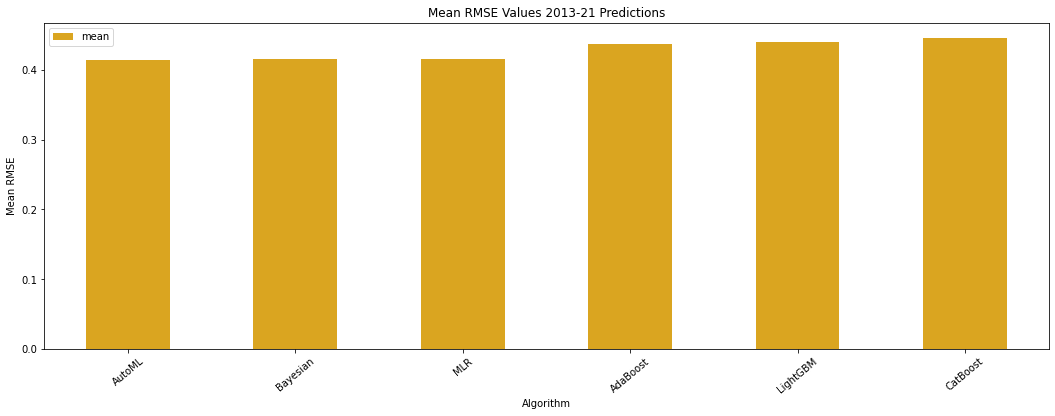

In [258]:
# rmse results
grouped_multiple1 = vis2.groupby(['Algorithm']).agg({'RMSE': ['mean', 'median', 'max', 'sum']})
grouped_multiple1.columns = ['mean','median','max','sum']
grouped_multiple1.reset_index(inplace = True)
distdf = grouped_multiple1.sort_values(by = ['mean'], ascending = True)
distdf.plot.bar(x = 'Algorithm', y = 'mean', rot = 40, figsize=(18, 6), color='goldenrod', xlabel='Algorithm', ylabel='Mean RMSE', title='Mean RMSE Values 2013-21 Predictions')

<AxesSubplot:title={'center':'Mean MEDAE Values 2013-21 Predictions'}, xlabel='Algorithm', ylabel='Mean MEDAE'>

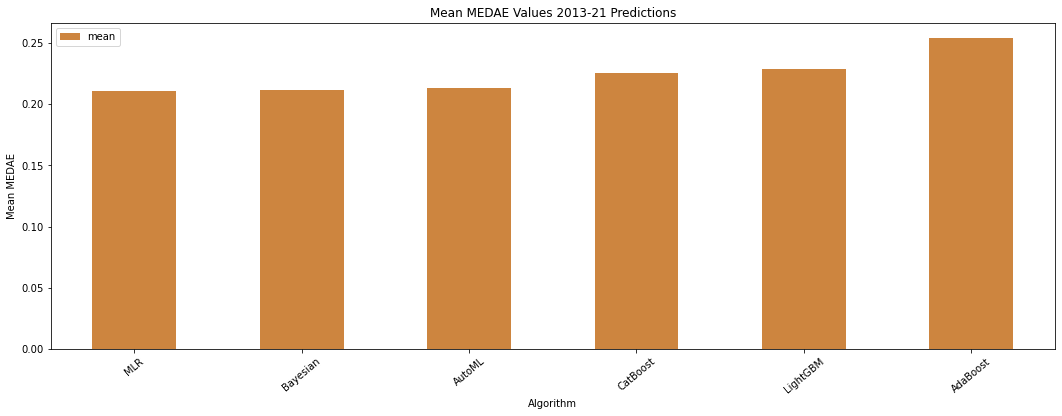

In [259]:
# median results
grouped_multiple2 = vis2.groupby(['Algorithm']).agg({'MEDAE': ['mean', 'median', 'max', 'sum']})
grouped_multiple2.columns = ['mean','median','max','sum']
grouped_multiple2.reset_index(inplace = True)
distdf = grouped_multiple2.sort_values(by = ['mean'], ascending = True)
distdf.plot.bar(x = 'Algorithm', y = 'mean', rot = 40, figsize=(18, 6), color='peru', xlabel='Algorithm', ylabel='Mean MEDAE', title='Mean MEDAE Values 2013-21 Predictions')

<AxesSubplot:title={'center':'Mean Accuracy Values 2013-21 Predictions'}, xlabel='Algorithm', ylabel='Average Accuracy'>

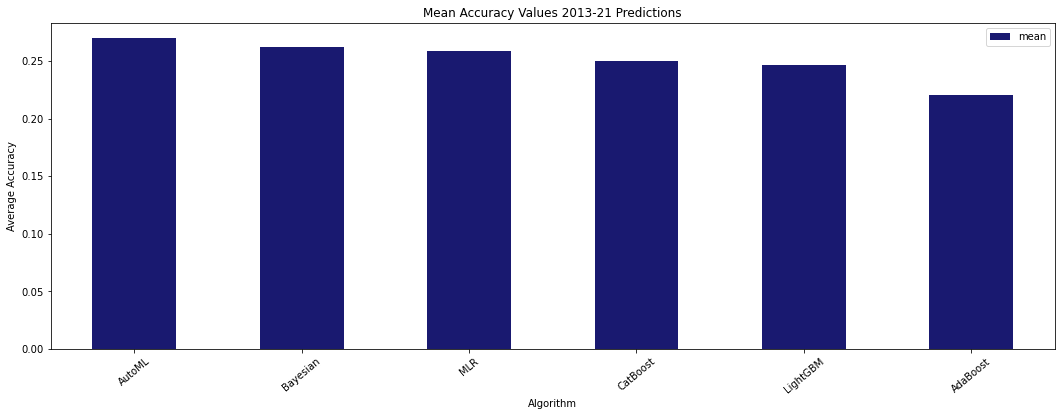

In [260]:
grouped_multiple3 = vis2.groupby(['Algorithm']).agg({'Accuracy': ['mean', 'median', 'max', 'sum', 'min']})
grouped_multiple3.columns = ['mean','median','max','sum', 'min']
grouped_multiple3.reset_index(inplace = True)
distdf = grouped_multiple3.sort_values(by = ['mean'], ascending = False)
distdf.plot.bar(x = 'Algorithm', y = 'mean', rot = 40, figsize=(18, 6), color='midnightblue', xlabel='Algorithm', ylabel='Average Accuracy', title='Mean Accuracy Values 2013-21 Predictions')

<AxesSubplot:title={'center':'Mean MSE Values 2013-21 Predictions'}, xlabel='Algorithm', ylabel='Mean MSE'>

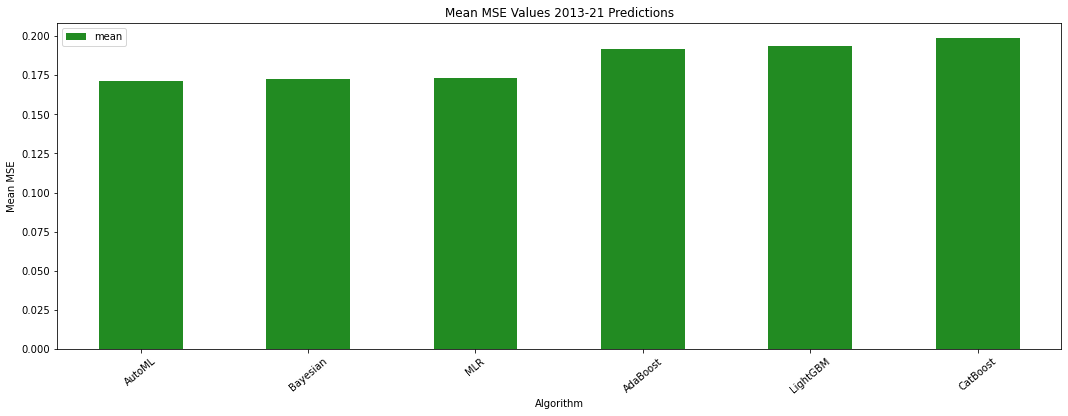

In [261]:
# mse results
grouped_multiple4 = vis2.groupby(['Algorithm']).agg({'MSE': ['mean', 'median', 'max', 'sum']})
grouped_multiple4.columns = ['mean','median','max','sum']
grouped_multiple4.reset_index(inplace = True)
distdf = grouped_multiple4.sort_values(by = ['mean'], ascending = True)
distdf.plot.bar(x = 'Algorithm', y = 'mean', rot = 40, figsize=(18, 6), color='forestgreen', xlabel='Algorithm', ylabel='Mean MSE', title='Mean MSE Values 2013-21 Predictions')

<AxesSubplot:title={'center':'Mean MAPE Values 2013-21 Predictions'}, xlabel='Algorithm', ylabel='Mean MAPE'>

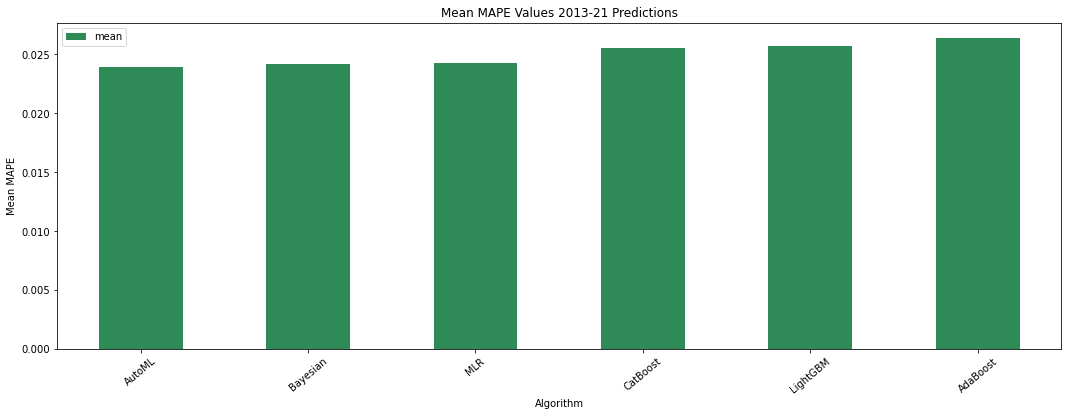

In [262]:
# mape results
grouped_multiple5 = vis2.groupby(['Algorithm']).agg({'MAPE': ['mean', 'median', 'max', 'sum']})
grouped_multiple5.columns = ['mean','median','max','sum']
grouped_multiple5.reset_index(inplace = True)
distdf = grouped_multiple5.sort_values(by = ['mean'], ascending = True)
distdf.plot.bar(x = 'Algorithm', y = 'mean', rot = 40, figsize=(18, 6), color='seagreen', xlabel='Algorithm', ylabel='Mean MAPE', title='Mean MAPE Values 2013-21 Predictions')

Result that can be compared around 6/7 % off [this](https://arxiv.org/pdf/2108.09175.pdf), (slightly diff approach taken by me predicting yearly however!)

In [263]:
grouped_multiple3.sort_values(by = 'mean', ascending = False)

,Algorithm,mean,median,max,sum,min
1,AutoML,0.269508,0.265252,0.304459,1.347538,0.233796
2,Bayesian,0.262432,0.257294,0.291720,1.312162,0.225322
5,MLR,0.259023,0.254642,0.285915,1.295114,0.222103
3,CatBoost,0.249595,0.232639,0.281529,1.247977,0.224249
4,LightGBM,0.246561,0.233422,0.282803,1.232805,0.213519
0,AdaBoost,0.220842,0.236074,0.284507,1.104211,0.159871


<AxesSubplot:title={'center':'Performance of ML algorithms accuracy from 2017-2021 Predictions'}, xlabel='Year'>

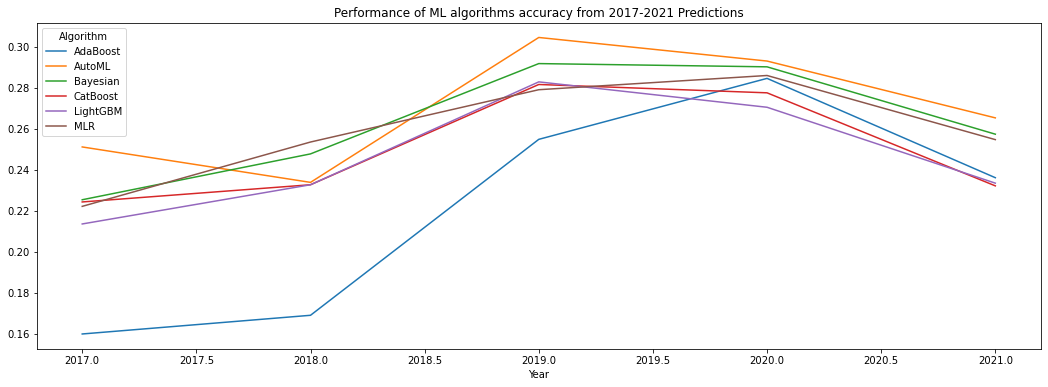

In [264]:
# yearly accuracy results
df = vis2.pivot(index = 'Year', columns = 'Algorithm', values = 'Accuracy')
df.plot(figsize = (18, 6), title = 'Performance of ML algorithms accuracy from 2017-2021 Predictions')

It is definitely worth noting the steep rise in performance of our prediction models after 2018. Looking at our AutoML approach in particular this sees a jump of 10% in predictive performance from 2018 to 2019 and remains well above 2017 and 2018 performance values. Looking across the board it definitely seems that our models are better suited to more up to date data, which is definitely a good thing. It may also suggest that the importance of our features changes noticeably over time with features such as closeness to parks and so forth maybe appearing more favourably in the midst of the global pandemic from 2020 onwards.

### Let's plot our Actual VS Predicted values for our best model - AutoML

In [265]:
actual = pd.concat([dfreal1, dfreal2, dfreal3, dfreal4, dfreal5], ignore_index=True)

In [266]:
actual.rename(columns = {0: 'Actual'}, inplace = True)
actual.head()

,Actual
0,11.976659
1,12.421184
2,12.028739
3,12.570716
4,12.367341


In [267]:
pred = pd.concat([dfpred1, dfpred2, dfpred3, dfpred4, dfpred5], ignore_index=True)

In [268]:
pred.rename(columns={0: 'Predicted'}, inplace = True)
pred.head()

,Predicted
0,11.962521
1,12.328492
2,11.954247
3,12.067077
4,12.496541


In [269]:
actualvpred = actual.join(pred)

In [270]:
actualvpred.head()

,Actual,Predicted
0,11.976659,11.962521
1,12.421184,12.328492
2,12.028739,11.954247
3,12.570716,12.067077
4,12.367341,12.496541


In [271]:
# actual prices for better plot
exp = np.exp(actualvpred)

In [272]:
exp.shape

(4045, 2)

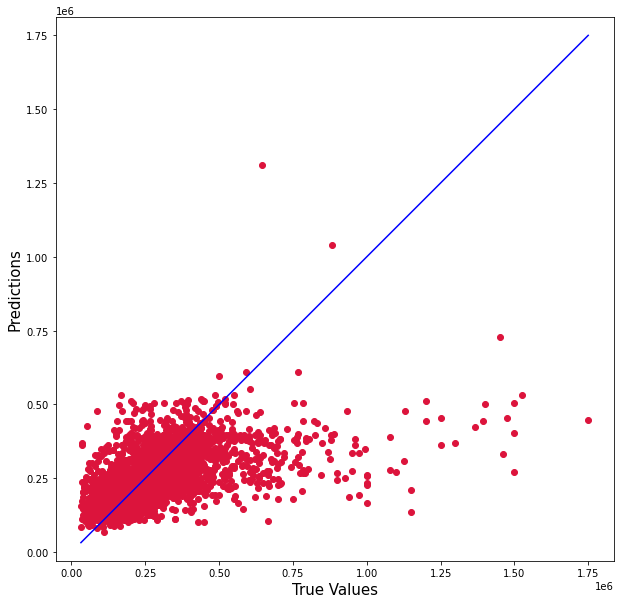

In [273]:
# plot predicted vs actual
plt.figure(figsize = (10, 10))
plt.scatter(exp['Actual'], exp['Predicted'], c = 'crimson')

p1 = max(max(exp['Predicted']), max(exp['Actual']))
p2 = min(min(exp['Predicted']), min(exp['Actual']))
plt.plot([p1, p2], [p1, p2], 'b-')
plt.xlabel('True Values', fontsize = 15)
plt.ylabel('Predictions', fontsize = 15)
plt.axis('equal')
plt.show()

### Predictions and True Values Evaluation

Our model is certainly most accurate between the 250,000€ to ~600,000€ range. There is definitely far more outliers as we increase our true values to around the 1,000,000€ mark. Some of these more expensive properties are definitely accurate (2 of note around 1.75m mark) but definitely we see it more accurate at the lower / average end of values. 

### Let's plot locations of our Properties and Accuracy of our results

In [274]:
import geopandas as gpd
cork_map = gpd.read_file('cork-city-boundary\Cork City BoundaryWGS84.shp')  #reading the shape file for our maps 
cork_map.head(1)

2022-04-09 22:19:10,379 fiona._env ERROR Unable to open EPSG support file gcs.csv.  Try setting the GDAL_DATA environment variable to point to the directory containing EPSG csv files.
2022-04-09 22:19:10,396 fiona._env ERROR Unable to open EPSG support file gcs.csv.  Try setting the GDAL_DATA environment variable to point to the directory containing EPSG csv files.


,Latitude,Longtitude,ENGLISH,CONTAE,COUNTY,AREA,PROVINCE,geometry
0,51.905,-8.384,CORK CITY COUNCIL,Corcaigh,CORK,186597605.50694406,Munster,"POLYGON ((-8.38436 51.90533, -8.38425 51.90529..."


### Location of Accurate VS Inaccurate

In [275]:
l1 = dfreal1.join(x_test_21[['Longitude', 'Latitude']])
l2 = dfreal2.join(x_test_20[['Longitude', 'Latitude']])
l3 = dfreal3.join(x_test_19[['Longitude', 'Latitude']])
l4 = dfreal4.join(x_test_18[['Longitude', 'Latitude']])
l5 = dfreal5.join(x_test_17[['Longitude', 'Latitude']])

In [276]:
plots = pd.concat([l1, l2, l3, l4, l5], ignore_index=True)

In [277]:
plots.rename(columns = {0 : 'Actual'}, inplace = True)

In [278]:
plotscomp = plots.join(pred)
plotscomp.head()

,Actual,Longitude,Latitude,Predicted
0,11.976659,-8.337650,51.873131,11.962521
1,12.421184,-8.445846,51.917272,12.328492
2,12.028739,-8.478741,51.915242,11.954247
3,12.570716,-8.461265,51.907005,12.067077
4,12.367341,-8.505025,51.882794,12.496541


In [279]:
exp1 = np.exp(plotscomp[['Actual', 'Predicted']])

In [280]:
exp1 = exp1.join(plotscomp[['Longitude', 'Latitude']])

In [281]:
exp1.head()

,Actual,Predicted,Longitude,Latitude
0,159000.0,156767.735776,-8.337650,51.873131
1,248000.0,226045.645437,-8.445846,51.917272
2,167500.0,155476.112940,-8.478741,51.915242
3,288000.0,174046.292219,-8.461265,51.907005
4,235000.0,267410.593791,-8.505025,51.882794


In [282]:
num = 0.1
lst = []
test = np.array(exp1['Actual'])
pred = np.array(exp1['Predicted'])
count = 0
for i in range(len(pred)):
    if test[i] != 0:  
        ten = test[i] * num
        res = test[i] - pred[i]
    else:
        res = 0
        ten = 0
        
    if res < 0:
        res = res * -1
    else:
        res = res
            
    if res <= ten:
        lst.append(1)
    else:
        lst.append(0)

In [283]:
exp1['Accurate'] = lst

In [284]:
exp1.head()

,Actual,Predicted,Longitude,Latitude,Accurate
0,159000.0,156767.735776,-8.337650,51.873131,1
1,248000.0,226045.645437,-8.445846,51.917272,1
2,167500.0,155476.112940,-8.478741,51.915242,1
3,288000.0,174046.292219,-8.461265,51.907005,0
4,235000.0,267410.593791,-8.505025,51.882794,0


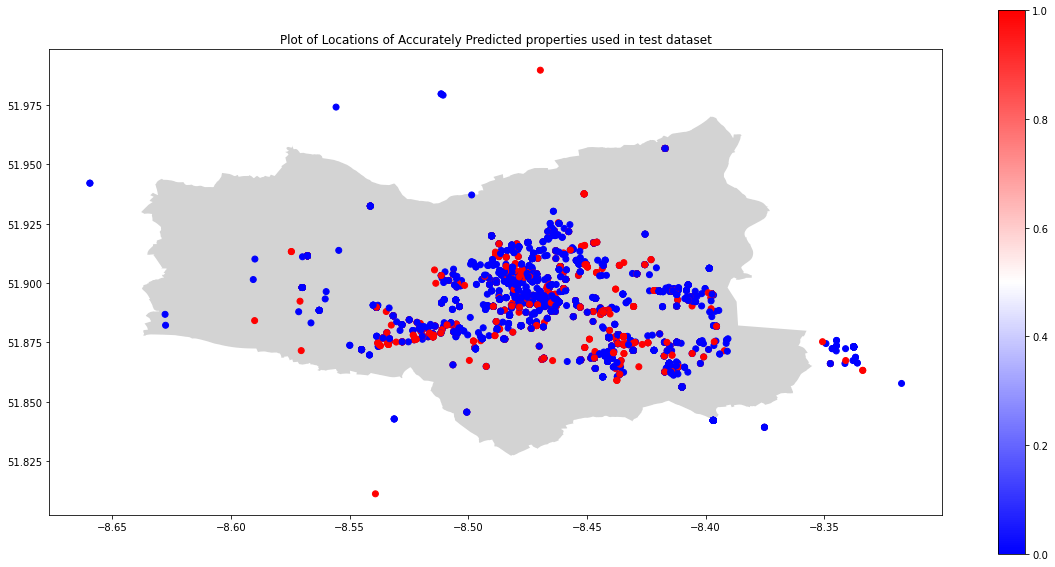

In [285]:
### RED = accurate , BLUE = Inaccurate
fig, ax = plt.subplots(figsize = (20, 10))
# O'Connell St. lat is 53.34975, and the longitude is -6.260113
cork_map.plot(ax = ax, color = 'lightgrey')
#ax.axhline(y = 53.34975, color = 'r', linestyle = '--')
plt.scatter(x = exp1['Longitude'], y = exp1['Latitude'], c = exp1['Accurate'], cmap = 'bwr')
plt.title('Plot of Locations of Accurately Predicted properties used in test dataset')
plt.colorbar()
plt.show()